# Simple Model 1

In [352]:
%load_ext autoreload
%autoreload 2
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import geopandas
import geopy
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, make_scorer
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium.plugins as plugins
import math
from math import sin, cos, sqrt, atan2, radians
from haversine import haversine
from itertools import combinations
%matplotlib inline
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)
from useful_functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
df = pd.read_csv('cleaned_data.csv')
len(df)

15851

In [87]:
# create a simple linear model with just one independent variable
# As single feature need to reshape X_train into column vector
df1 = df.copy()
X_train = np.array(df1['SqFtTotLiving']).reshape(-1,1)
y_train = df1['SalePrice']

In [88]:
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                 1.010e+04
Date:                Thu, 04 Mar 2021   Prob (F-statistic):               0.00
Time:                        19:32:43   Log-Likelihood:            -2.2843e+05
No. Observations:               15851   AIC:                         4.569e+05
Df Residuals:                   15849   BIC:                         4.569e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9291.9955   8504.112     -1.093      0.275    -2.6e+04    7377.030
x1           374.8940      3.730    100.509      0.000     367.583     382.205
==============================================================================
Omnibus:                    19945.027   Durbin-Watson:                   0.685
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          9825842.224
Skew:                           6.470   Prob(JB):                         0.00
Kurtosis:                     124.284   Cond. No.                     5.56e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Ok so there are issues with this model of course, only a single feature has been used. It still manages to explain 39% of the variance in SalePrice, which I'm actually surprised at - this suggests the total square footage of living space is an important factor in house prices - perhaps this is less surprising!

C:\Users\Andrew\Documents\Flatiron\Course\phase_2\project\110920-pt-phase-2-project\useful_functions.py:69: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


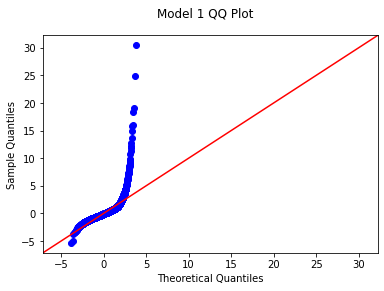

In [89]:
get_qq(model, 'Model 1')

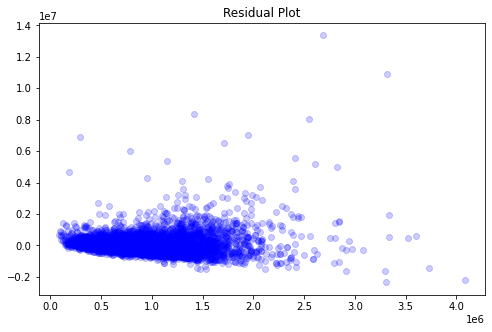

In [90]:
get_resid(df1, model)

In [91]:
# I will now check run the model using sk-learn
linreg = LinearRegression()

# Fit on training data
linreg.fit(X_train, y_train)

scores = cross_val_score(
            linreg, 
            X_train,
            y_train,
            cv=10,
            scoring="neg_mean_squared_error"
)

rmse_scores = np.sqrt(-scores)
display(rmse_scores)
display(rmse_scores.mean())
display(rmse_scores.std())

array([ 273996.8099302 ,  262073.65662739,  298476.26954476,
        306525.03804902,  290063.51526738,  256734.93056669,
        270496.02301345,  273578.29343339,  330007.16912153,
       1424165.40108199])

398611.71066358173

342506.0943804986

In [107]:
# Define table as a dataframe with specific columns. Each column's values will be a list that we will add to.
summary = pd.DataFrame({'Model': [], 'Description':[], ' No. Features' : [], 'R^2':[],
                                'Adj R^2':[], 'RMSE': [],'RMSE sd':[], 'JB':[]})

# Add data for simple linear regression
summary.loc[0] = ['Simple Model - one independent variable', 'Square ft Total living', model.df_model, round(model.rsquared,3)\
                  , round(model.rsquared_adj,3), int(rmse_scores.mean()), int(rmse_scores.std()), round((sms.jarque_bera(model.resid)[0]),0)]

summary

Model             Description  \
0  Simple Model - one independent variable  Square ft Total living   

    No. Features    R^2  Adj R^2      RMSE   RMSE sd         JB  
0            1.0  0.389    0.389  398611.0  342506.0  9825842.0

It is pretty clear that this model violates the assumptions that residuals are normally distributed. This is also reflected with the extremely high JB number. The mean squared error is also very high, 398,611USD meaning that on average the house price predicted by the model could be +/- 400k USD away from the actual value - not the best. 

I will remove outliers from this model to try and improve these metrics.

# Simple Model 2 (outliers removed)

In [110]:
df2 = df.copy()
df2 = drop_outliers(df2, 'SalePrice', 3)
df2 = drop_outliers(df2, 'SqFtTotLiving', 3)

In [111]:
X_train2 = np.array(df2['SqFtTotLiving']).reshape(-1,1)
y_train2 = df2['SalePrice']

In [112]:
X_int2 = sm.add_constant(X_train2)
model2 = sm.OLS(y_train2, X_int2).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     8444.
Date:                Thu, 04 Mar 2021   Prob (F-statistic):               0.00
Time:                        20:26:43   Log-Likelihood:            -2.1568e+05
No. Observations:               15411   AIC:                         4.314e+05
Df Residuals:                   15409   BIC:                         4.314e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.671e+05   6371.126     26.230      0.000    1.55e+05     1.8e+05
x1           272.4155      2.965     91.893      0.000     266.605     278.226
==============================================================================
Omnibus:                     2916.013   Durbin-Watson:                   0.678
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7132.340
Skew:                           1.055   Prob(JB):                         0.00
Kurtosis:                       5.579   Cond. No.                     5.87e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.87e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

C:\Users\Andrew\Documents\Flatiron\Course\phase_2\project\110920-pt-phase-2-project\useful_functions.py:66: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


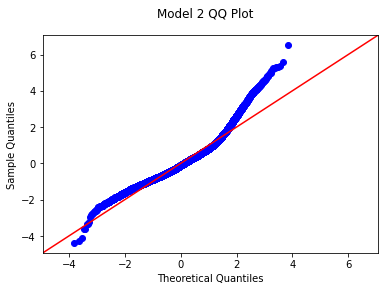

In [113]:
get_qq(model2, 'Model 2')

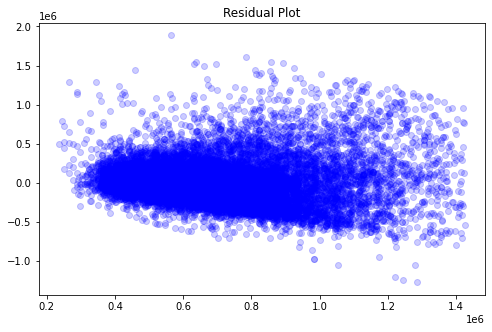

In [114]:
get_resid(df2, model2)

In [126]:
# I will now check run the model using sk-learn
linreg = LinearRegression()

# Fit on training data
linreg2 = linreg.fit(X_train2, y_train2)

scores2 = cross_val_score(
            linreg2, 
            X_train2,
            y_train2,
            cv=10,
            scoring="neg_mean_squared_error"
)

rmse_scores2 = np.sqrt(-scores2)
display(rmse_scores2)
display(rmse_scores2.mean())
display(rmse_scores2.std())

array([295321.18953263, 249736.38151031, 258494.96890691, 245105.5103492 ,
       227426.37390392, 184883.81296618, 199095.84250856, 214193.43679246,
       279496.28324522, 792045.29417882])

294579.90938941936

168991.91647047078

In [127]:
summary.loc[1] = ['Simple Model - outliers removed', 'Square ft Total living', model2.df_model, round(model2.rsquared,3)\
                  , round(model2.rsquared_adj,3), int(rmse_scores2.mean()), int(rmse_scores2.std()), round((sms.jarque_bera(model2.resid)[0]),0)]

summary

Model             Description  \
0  Simple Model - one independent variable  Square ft Total living   
1          Simple Model - outliers removed  Square ft Total living   

    No. Features    R^2  Adj R^2      RMSE   RMSE sd         JB  
0            1.0  0.389    0.389  398611.0  342506.0  9825842.0  
1            1.0  0.354    0.354  294579.0  168991.0     7132.0

Interesting that the R-squared value reduced, but the JB number has reduced significantly, and checking the qq plot it appears to be somewhat honouring residuals normality assumption to some extent, certainly better than previously. It is not honouring the homoscedasticity assumption.

# Model 3 - Adding Features

Before adding new features, its important to check that they are have a linear relationship with SalePrice. This can be checked visually by plotting each potential feature vs SalePrice

In [132]:
# work from the dataframe that had outliers in price and sqfttotliving removed 
df3 = df2.copy()
df3.drop(columns=['Unnamed: 0'], inplace=True)

In [133]:
df3.columns

Index(['Address', 'BuildingNumber', 'DirectionPrefix', 'StreetName',
       'StreetType', 'DirectionSuffix', 'ZipCode', 'Stories', 'BldgGrade',
       'SqFt1stFloor', 'SqFtHalfFloor', 'SqFt2ndFloor', 'SqFtUpperFloor',
       'SqFtTotLiving', 'SqFtTotBasement', 'SqFtFinBasement',
       'FinBasementGrade', 'SqFtGarageBasement', 'SqFtGarageAttached',
       'DaylightBasement', 'SqFtOpenPorch', 'SqFtEnclosedPorch', 'SqFtDeck',
       'HeatSystem', 'HeatSource', 'BrickStone', 'ViewUtilization', 'Bedrooms',
       'BathHalfCount', 'Bath3qtrCount', 'BathFullCount', 'YrBuilt',
       'YrRenovated', 'Condition', 'id', 'Township', 'Section',
       'QuarterSection', 'Area', 'DistrictName', 'SqFtLot', 'Access',
       'Topography', 'InadequateParking', 'MtRainier', 'Olympics', 'Cascades',
       'Territorial', 'SeattleSkyline', 'PugetSound', 'LakeWashington',
       'LakeSammamish', 'SmallLakeRiverCreek', 'OtherView', 'WfntLocation',
       'TrafficNoise', 'PowerLines', 'OtherNuisances', 'Adjace

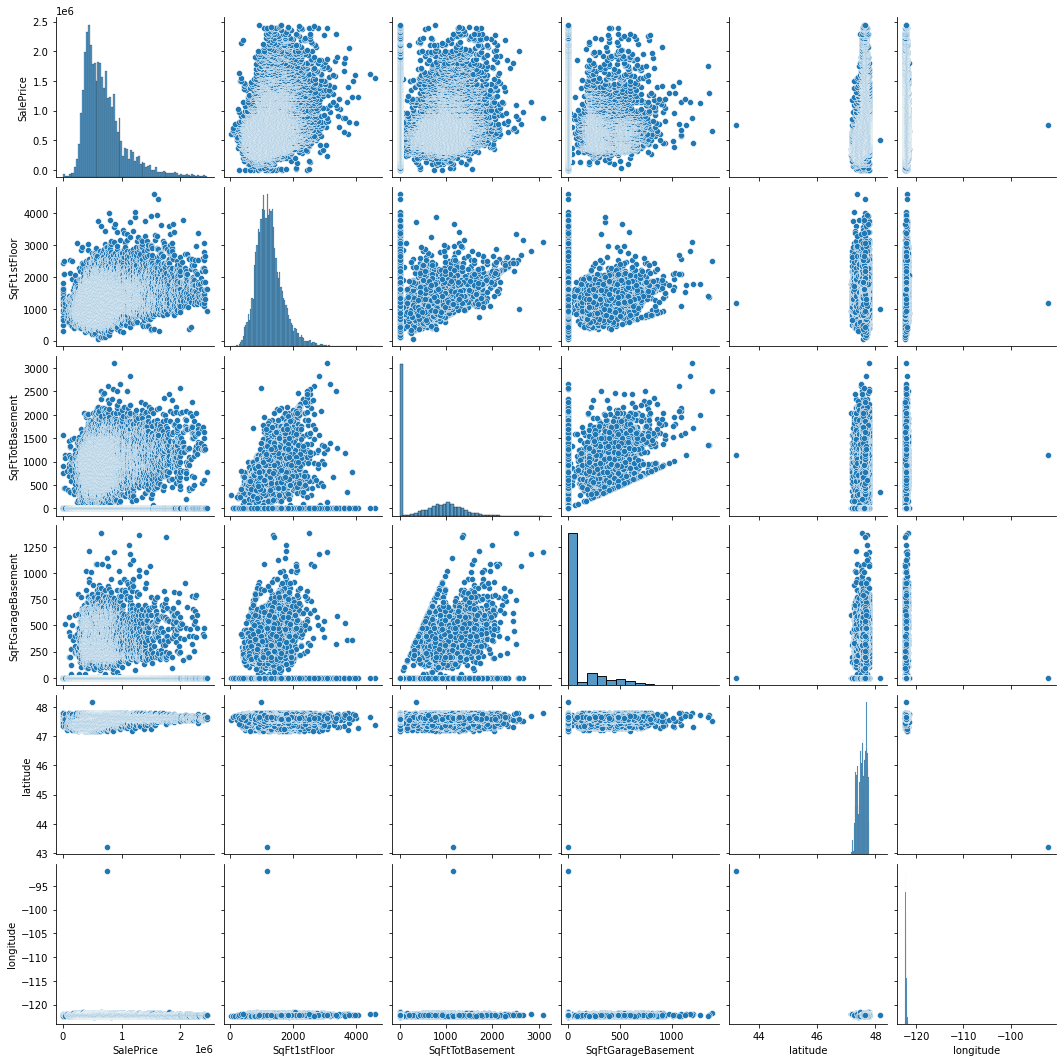

In [134]:
cont_pairplot = ['SalePrice','SqFt1stFloor','SqFtTotBasement','SqFtGarageBasement', 'latitude', 'longitude']

sns.pairplot(df3[cont_pairplot]);

These plots not very useful in their current state, however they have highlighted the need to remove further outliers..

In [135]:
df3 = drop_outliers(df3, 'latitude', 3)
df3 = drop_outliers(df3, 'longitude', 3)

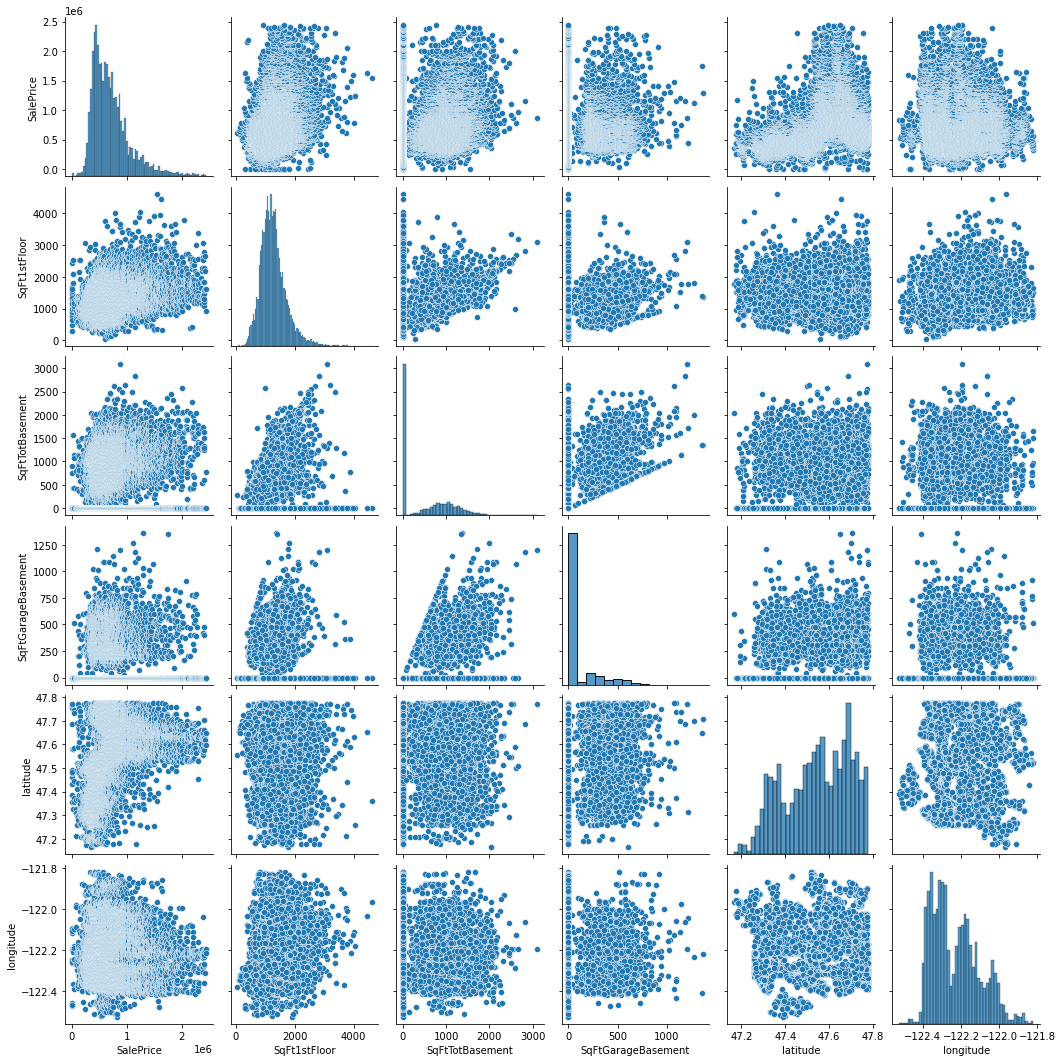

In [136]:
sns.pairplot(df3[cont_pairplot])

Messy data which is difficult to spot useful correlations but I think there are some trends particularly with SqfT1stFloor and latitude/longitude. It may be better to change some of these features into binary columns due to the high number of zeroes in each. For example SqFtGarageBasement could become (has_garagebasement).Aside from that, looking at the histograms, none of the features are normally distributed and could probably benefit from log transformation. 

In [138]:
# drop outliers from 'SqFt1stFloor'
df3 = drop_outliers(df3, 'SqFt1stFloor', 3)

In [139]:
features_3 = ['SqFtTotLiving','SqFt1stFloor', 'latitude', 'longitude']
X_train3 = df3[features_3]
y_train3 = df3['SalePrice']
X_int3 = sm.add_constant(X_train3)
model3 = sm.OLS(y_train3, X_int3).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     4327.
Date:                Thu, 04 Mar 2021   Prob (F-statistic):               0.00
Time:                        21:08:04   Log-Likelihood:            -2.0765e+05
No. Observations:               15030   AIC:                         4.153e+05
Df Residuals:                   15025   BIC:                         4.154e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -7.291e+07   2.05e+06    -35.589      0.000   -7.69e+07   -6.89e+07
SqFtTotLiving   275.8215      3.236     85.238      0.000     269.479     282.164
SqFt1stFloor    -27.4989      6.371     -4.316      0.000     -39.988     -15.010
latitude       1.007e+06   1.37e+04     73.621      0.000     9.8e+05    1.03e+06
longitude     -2.064e+05   1.66e+04    -12.414      0.000   -2.39e+05   -1.74e+05
==============================================================================
Omnibus:                     4182.863   Durbin-Watson:                   0.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18348.360
Skew:                           1.302   Prob(JB):                         0.00
Kurtosis:                       7.746   Cond. No.                     2.56e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.56e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

C:\Users\Andrew\Documents\Flatiron\Course\phase_2\project\110920-pt-phase-2-project\useful_functions.py:66: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


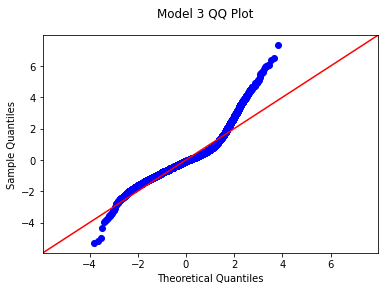

In [142]:
get_qq(model3, 'Model 3')

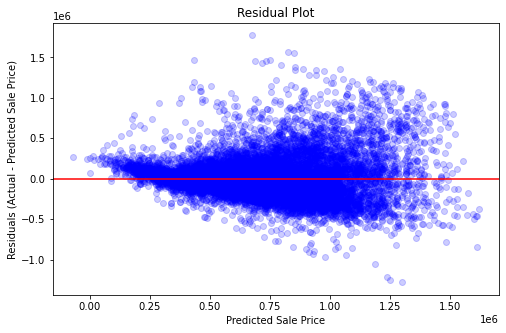

In [147]:
get_resid(df3, model3)

In [140]:
# I will now check run the model using sk-learn
linreg = LinearRegression()

# Fit on training data
linreg3 = linreg.fit(X_train3, y_train3)

scores3 = cross_val_score(
            linreg3, 
            X_train3,
            y_train3,
            cv=10,
            scoring="neg_mean_squared_error"
)

rmse_scores3 = np.sqrt(-scores3)
display(rmse_scores3)
display(rmse_scores3.mean())
display(rmse_scores3.std())

array([201621.90629106, 140021.17393374, 163362.731922  , 189984.793088  ,
       202981.05367913, 195349.80303403, 183373.5191414 , 181095.90337485,
       217366.9863357 , 711475.09932703])

238663.29701269456

158954.98852596313

In [141]:
summary.loc[2] = ['Multiple Linear Model 1', 'Continuous features', model3.df_model, round(model3.rsquared,3)\
                  , round(model3.rsquared_adj,3), int(rmse_scores3.mean()), int(rmse_scores3.std()),\
                  round((sms.jarque_bera(model3.resid)[0]),0)]

summary

Model             Description  \
0  Simple Model - one independent variable  Square ft Total living   
1          Simple Model - outliers removed  Square ft Total living   
2                  Multiple Linear Model 1     Continuous features   

    No. Features    R^2  Adj R^2      RMSE   RMSE sd         JB  
0            1.0  0.389    0.389  398611.0  342506.0  9825842.0  
1            1.0  0.354    0.354  294579.0  168991.0     7132.0  
2            4.0  0.535    0.535  238663.0  158954.0    18348.0

# Model 4 (Distance to Expensive Areas and Age Features Added)

1. Most expensive house in mercer island is in 5330 Butterworth Rd, Mercer Island, Washington
2. Most expensive house in medina is in medina 7887 Overlake Drive West
3. NE Laurelcrest Lane has the most expensive house in Seattle. 
4. Another populous area is Kent. 148th Ave SE is the most expensive neighbourhood in Kent and quite populous, I will add these four locations using Geocode

In [149]:
from geopy.geocoders import Nominatim
expensive = ['5330 Butterworth Rd, Mercer Island, Washington', '7887 Overlake Drive West, Medina, WA',\
            'NE Laurelcrest Lane, Seattle, WA', '148th Ave SE, Kent, WA']
locator = Nominatim(user_agent='myGeocoder')
for loc in expensive:
    location = locator.geocode(loc)
    print(loc)
    print('Latitude = {}, Longitude = {}'.format(location.latitude, location.longitude))

5330 Butterworth Rd, Mercer Island, Washington
Latitude = 47.55621241561222, Longitude = -122.2129871659772
7887 Overlake Drive West, Medina, WA
Latitude = 47.6160689485921, Longitude = -122.23362543624816
NE Laurelcrest Lane, Seattle, WA
Latitude = 47.6560723, Longitude = -122.2725167
148th Ave SE, Kent, WA
Latitude = 47.3844953, Longitude = -122.1426915


In [150]:
laurelcrest = [47.6560723, -122.2725167]
medina = [47.6160689485921,-122.23362543624816] 
mercer = [47.55621241561222, -122.2129871659772]
kent = [47.3844953, -122.1426915]

In [151]:
df4 = df3.copy()

In [154]:
# create column in df4 with tuple containing lat long info
df4['lat_long'] = tuple(zip(df4.latitude, df4.longitude))
# calculate distance to each of the four expensive areas highlighted and create a column for it
df4['laurelcrest'] = calc_distances(df4['lat_long'], laurelcrest, df4)
df4['medina'] = calc_distances(df4['lat_long'], medina, df4)
df4['mercer'] = calc_distances(df4['lat_long'], mercer, df4)
df4['kent'] = calc_distances(df4['lat_long'], kent, df4)

# new column with the minimum value across these four columns
df4['dist_to_exp'] = df4[['laurelcrest', 'medina', 'mercer', 'kent']].min(axis=1, numeric_only=True)

#drop the rest original 4 and work with minimum distance to an expensive area
df4.drop(['laurelcrest', 'medina', 'mercer', 'kent'], axis=1, inplace=True)

C:\Users\Andrew\anaconda3\envs\geo-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


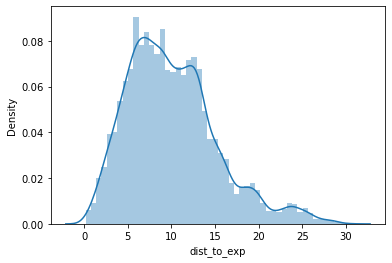

In [157]:
sns.distplot(df4.dist_to_exp);

C:\Users\Andrew\anaconda3\envs\geo-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

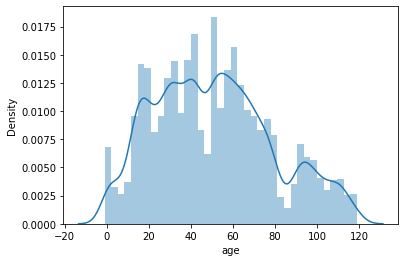

In [160]:
# create a new column for age feature
df4['age'] = 2019 - df4['YrBuilt']
sns.distplot(df4.age)

In [161]:
features_4 = ['SqFtTotLiving','SqFt1stFloor', 'latitude', 'longitude', 'dist_to_exp', 'age']
X_train4 = df4[features_4]
y_train4 = df4['SalePrice']
X_int4 = sm.add_constant(X_train4)
model4 = sm.OLS(y_train4, X_int4).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     3274.
Date:                Thu, 04 Mar 2021   Prob (F-statistic):               0.00
Time:                        21:57:17   Log-Likelihood:            -2.0713e+05
No. Observations:               15030   AIC:                         4.143e+05
Df Residuals:                   15023   BIC:                         4.143e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -4.927e+07   2.18e+06    -22.633      0.000   -5.35e+07    -4.5e+07
SqFtTotLiving   288.1086      3.320     86.790      0.000     281.602     294.615
SqFt1stFloor    -31.7000      6.287     -5.042      0.000     -44.024     -19.376
latitude       9.297e+05   1.35e+04     69.111      0.000    9.03e+05    9.56e+05
longitude     -4.327e+04   1.73e+04     -2.498      0.013   -7.72e+04   -9309.938
dist_to_exp   -1.057e+04    382.960    -27.596      0.000   -1.13e+04   -9817.377
age            1149.7452     79.533     14.456      0.000     993.850    1305.640
==============================================================================
Omnibus:                     3693.396   Durbin-Watson:                   0.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16023.068
Skew:                           1.145   Prob(JB):                         0.00
Kurtosis:                       7.510   Cond. No.                     2.82e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.82e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [162]:
# I will now check run the model using sk-learn
linreg = LinearRegression()

# Fit on training data
linreg4 = linreg.fit(X_train4, y_train4)

scores4 = cross_val_score(
            linreg4, 
            X_train4,
            y_train4,
            cv=10,
            scoring="neg_mean_squared_error"
)

rmse_scores4 = np.sqrt(-scores4)
display(rmse_scores4)
display(rmse_scores4.mean())
display(rmse_scores4.std())

array([215374.88198928, 152968.68682059, 173107.84178114, 194312.91145496,
       201461.19390044, 185550.77147204, 177070.46518006, 173715.50766365,
       201522.77926357, 694540.85168871])

236962.5891214435

153473.79543835213

In [164]:
summary.loc[3] = ['Multiple Linear Model 2', 'Continuous features + age/dist_to_exp', model4.df_model, round(model4.rsquared,3)\
                  , round(model4.rsquared_adj,3), int(rmse_scores4.mean()), int(rmse_scores4.std()),\
                  round((sms.jarque_bera(model4.resid)[0]),0)]

summary

Model  \
0  Simple Model - one independent variable   
1          Simple Model - outliers removed   
2                  Multiple Linear Model 1   
3                  Multiple Linear Model 2   

                             Description   No. Features    R^2  Adj R^2  \
0                 Square ft Total living            1.0  0.389    0.389   
1                 Square ft Total living            1.0  0.354    0.354   
2                    Continuous features            4.0  0.535    0.535   
3  Continuous features + age/dist_to_exp            6.0  0.567    0.566   

       RMSE   RMSE sd         JB  
0  398611.0  342506.0  9825842.0  
1  294579.0  168991.0     7132.0  
2  238663.0  158954.0    18348.0  
3  236962.0  153473.0    16023.0

# Model 5 - Add Binary Features

The next model I will test is one with the binary columns added to see what impact this will have.

In [165]:
df5 = df4.copy()
df5.columns

Index(['Address', 'BuildingNumber', 'DirectionPrefix', 'StreetName',
       'StreetType', 'DirectionSuffix', 'ZipCode', 'Stories', 'BldgGrade',
       'SqFt1stFloor', 'SqFtHalfFloor', 'SqFt2ndFloor', 'SqFtUpperFloor',
       'SqFtTotLiving', 'SqFtTotBasement', 'SqFtFinBasement',
       'FinBasementGrade', 'SqFtGarageBasement', 'SqFtGarageAttached',
       'DaylightBasement', 'SqFtOpenPorch', 'SqFtEnclosedPorch', 'SqFtDeck',
       'HeatSystem', 'HeatSource', 'BrickStone', 'ViewUtilization', 'Bedrooms',
       'BathHalfCount', 'Bath3qtrCount', 'BathFullCount', 'YrBuilt',
       'YrRenovated', 'Condition', 'id', 'Township', 'Section',
       'QuarterSection', 'Area', 'DistrictName', 'SqFtLot', 'Access',
       'Topography', 'InadequateParking', 'MtRainier', 'Olympics', 'Cascades',
       'Territorial', 'SeattleSkyline', 'PugetSound', 'LakeWashington',
       'LakeSammamish', 'SmallLakeRiverCreek', 'OtherView', 'WfntLocation',
       'TrafficNoise', 'PowerLines', 'OtherNuisances', 'Adjace

In [177]:
# engineer column for traffic noise
df5.loc[df5['TrafficNoise']!= 0, 'TrafficNoise'] = 1

# engineer a column for has_basement
df5['has_basement'] = 0
df5.loc[(df5['SqFtGarageBasement']!= 0)|(df5['SqFtTotBasement']!= 0)|\
        (df5['DaylightBasement']!= 0), 'has_basement'] = 1

# engineer a column for has_deck
df5['has_deck'] = 0
df5.loc[(df5['SqFtDeck']!= 0),'has_deck'] = 1

# engineer a column for has_porch
df5['has_porch'] = 0
df5.loc[(df5['SqFtOpenPorch']!= 0)|(df5['SqFtEnclosedPorch']!= 0), 'has_porch'] = 1

# engineer a column for has_renovation
df5['has_renovation'] = 0
df5.loc[df5['YrRenovated'] != 0, 'has_renovation'] = 1

# engineer a column for has_problem
df5['has_problem'] = 0
df5.loc[(df5['PowerLines'] != 0)|(df5['OtherNuisances'] != 0), 'has_problem'] = 1


In [181]:
binary_cols5 = ['AdjacentGreenbelt','excellent_view','Topography', 'InadequateParking', 'MtRainier',\
               'Olympics', 'Cascades','Territorial', 'SeattleSkyline', 'PugetSound', 'LakeWashington','LakeSammamish',\
               'SmallLakeRiverCreek', 'OtherView', 'WfntLocation', 'Easements', 'SaleWarning', 'ViewUtilization',
               'has_porch', 'has_renovation', 'has_basement', 'TrafficNoise', 'has_problem']

cont_5 = ['SqFtTotLiving','SqFt1stFloor', 'latitude', 'longitude', 'dist_to_exp', 'age']

In [184]:
features_5 = binary_cols5 + cont_5
X_train5 = df5[features_5]
y_train5 = df5['SalePrice']
X_int5 = sm.add_constant(X_train5)
model5 = sm.OLS(y_train5, X_int5).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     852.7
Date:                Thu, 04 Mar 2021   Prob (F-statistic):               0.00
Time:                        22:29:28   Log-Likelihood:            -2.0609e+05
No. Observations:               15030   AIC:                         4.122e+05
Df Residuals:                   15000   BIC:                         4.125e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -4.473e+07   2.19e+06    -20.387      0.000    -4.9e+07   -4.04e+07
AdjacentGreenbelt    1.538e+04   1.18e+04      1.308      0.191   -7662.162    3.84e+04
excellent_view        1.13e+05   1.93e+04      5.853      0.000    7.52e+04    1.51e+05
Topography           1.856e+04   6930.618      2.677      0.007    4971.100    3.21e+04
InadequateParking    3.499e+04   3690.286      9.482      0.000    2.78e+04    4.22e+04
MtRainier            7.174e+04   2.15e+04      3.342      0.001    2.97e+04    1.14e+05
Olympics             7.625e+04    1.6e+04      4.775      0.000    4.49e+04    1.08e+05
Cascades            -6411.7770   1.32e+04     -0.485      0.627   -3.23e+04    1.95e+04
Territorial          5629.9652   9303.120      0.605      0.545   -1.26e+04    2.39e+04
SeattleSkyline       1.806e+05   2.13e+04      8.482      0.000    1.39e+05    2.22e+05
PugetSound           9.376e+04   1.44e+04      6.503      0.000    6.55e+04    1.22e+05
LakeWashington       1.588e+05    1.4e+04     11.338      0.000    1.31e+05    1.86e+05
LakeSammamish        3.203e+05   2.85e+04     11.239      0.000    2.64e+05    3.76e+05
SmallLakeRiverCreek -3.239e+04   2.64e+04     -1.229      0.219   -8.41e+04    1.93e+04
OtherView             1.02e+05   3.15e+04      3.234      0.001    4.02e+04    1.64e+05
WfntLocation         2.695e+05   2.38e+04     11.321      0.000    2.23e+05    3.16e+05
Easements            2.628e+04   1.32e+04      1.985      0.047     335.462    5.22e+04
SaleWarning         -1.038e+05   7446.043    -13.945      0.000   -1.18e+05   -8.92e+04
ViewUtilization      1.977e+05   1.39e+04     14.211      0.000     1.7e+05    2.25e+05
has_porch            4.345e+04   3772.634     11.516      0.000    3.61e+04    5.08e+04
has_renovation       5.696e+04   8279.590      6.880      0.000    4.07e+04    7.32e+04
has_basement        -1.747e+04   4306.812     -4.057      0.000   -2.59e+04   -9030.786
TrafficNoise        -3.003e+04   5205.521     -5.769      0.000   -4.02e+04   -1.98e+04
has_problem         -2.974e+04   9259.612     -3.211      0.001   -4.79e+04   -1.16e+04
SqFtTotLiving         251.4487      3.557     70.700      0.000     244.477     258.420
SqFt1stFloor          -16.5864      6.160     -2.693      0.007     -28.661      -4.512
latitude             9.458e+05   1.28e+04     73.632      0.000    9.21e+05    9.71e+05
longitude            -103.5302   1.75e+04     -0.006      0.995   -3.43e+04    3.41e+04
dist_to_exp         -1.147e+04    371.311    -30.882      0.000   -1.22e+04   -1.07e+04
age                   922.0280     81.847     11.265      0.000     761.598    1082.458
==============================================================================
Omnibus:                     3390.296   Durbin-Watson:                   1.049
Prob(Omnibus):       

In [185]:
# I will now check run the model using sk-learn
linreg = LinearRegression()

# Fit on training data
linreg5 = linreg.fit(X_train5, y_train5)

scores5 = cross_val_score(
            linreg5, 
            X_train5,
            y_train5,
            cv=10,
            scoring="neg_mean_squared_error"
)

rmse_scores5 = np.sqrt(-scores5)
display(rmse_scores5)
display(rmse_scores5.mean())
display(rmse_scores5.std())

array([209955.6801617 , 142784.92231253, 162558.27142548, 181399.6617275 ,
       188908.94376808, 176733.07227389, 170209.56608749, 171807.44077743,
       205131.39188023, 663269.84225369])

227275.879266802

146517.14238741784

C:\Users\Andrew\Documents\Flatiron\Course\phase_2\project\110920-pt-phase-2-project\useful_functions.py:66: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


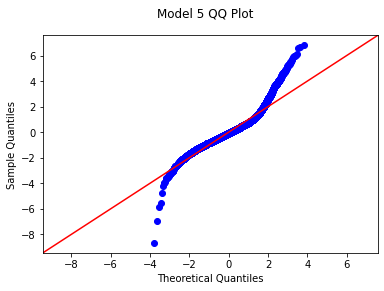

In [188]:
get_qq(model5, 'Model 5')

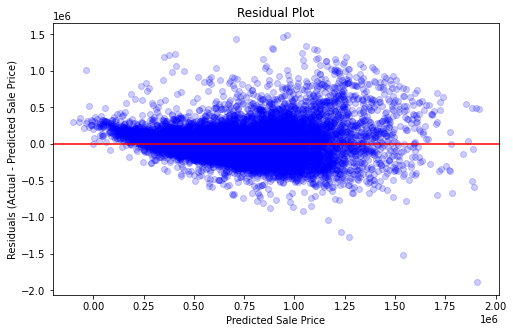

In [187]:
get_resid(df5, model5)

In [186]:
summary.loc[4] = ['Multiple Linear Model 3', 'continuous + binary features', model5.df_model, round(model5.rsquared,3)\
                  , round(model5.rsquared_adj,3), int(rmse_scores5.mean()), int(rmse_scores5.std()),\
                  round((sms.jarque_bera(model5.resid)[0]),0)]

summary

Model  \
0  Simple Model - one independent variable   
1          Simple Model - outliers removed   
2                  Multiple Linear Model 1   
3                  Multiple Linear Model 2   
4                  Multiple Linear Model 3   

                             Description   No. Features    R^2  Adj R^2  \
0                 Square ft Total living            1.0  0.389    0.389   
1                 Square ft Total living            1.0  0.354    0.354   
2                    Continuous features            4.0  0.535    0.535   
3  Continuous features + age/dist_to_exp            6.0  0.567    0.566   
4           continuous + binary features           29.0  0.622    0.622   

       RMSE   RMSE sd         JB  
0  398611.0  342506.0  9825842.0  
1  294579.0  168991.0     7132.0  
2  238663.0  158954.0    18348.0  
3  236962.0  153473.0    16023.0  
4  227275.0  146517.0    16416.0

# Model 6 - Adding Categorical Features

ok now it is time to add further categorical features, however, we will need to onehotencode them first. 

In [189]:
df5.columns

Index(['Address', 'BuildingNumber', 'DirectionPrefix', 'StreetName',
       'StreetType', 'DirectionSuffix', 'ZipCode', 'Stories', 'BldgGrade',
       'SqFt1stFloor', 'SqFtHalfFloor', 'SqFt2ndFloor', 'SqFtUpperFloor',
       'SqFtTotLiving', 'SqFtTotBasement', 'SqFtFinBasement',
       'FinBasementGrade', 'SqFtGarageBasement', 'SqFtGarageAttached',
       'DaylightBasement', 'SqFtOpenPorch', 'SqFtEnclosedPorch', 'SqFtDeck',
       'HeatSystem', 'HeatSource', 'BrickStone', 'ViewUtilization', 'Bedrooms',
       'BathHalfCount', 'Bath3qtrCount', 'BathFullCount', 'YrBuilt',
       'YrRenovated', 'Condition', 'id', 'Township', 'Section',
       'QuarterSection', 'Area', 'DistrictName', 'SqFtLot', 'Access',
       'Topography', 'InadequateParking', 'MtRainier', 'Olympics', 'Cascades',
       'Territorial', 'SeattleSkyline', 'PugetSound', 'LakeWashington',
       'LakeSammamish', 'SmallLakeRiverCreek', 'OtherView', 'WfntLocation',
       'TrafficNoise', 'PowerLines', 'OtherNuisances', 'Adjace

In [198]:
features_6 = ['AdjacentGreenbelt', 'excellent_view', 'Topography', 'InadequateParking', 'MtRainier', 'Olympics', 'Cascades',\
               'Territorial', 'SeattleSkyline', 'PugetSound', 'LakeWashington', 'LakeSammamish', 'SmallLakeRiverCreek',\
               'OtherView', 'WfntLocation', 'Easements', 'SaleWarning', 'ViewUtilization', 'has_porch', 'has_renovation',\
              'has_basement', 'TrafficNoise', 'has_problem', 'SqFtTotLiving', 'SqFt1stFloor', 'latitude', 'longitude',\
               'dist_to_exp', 'age', 'SalePrice']

Prior to adding in ZipCodes into the analysis, I will have a quick QC of the values. I don't think including zips with few entries will be valuable

In [234]:
df6 = df5.copy()
df6.ZipCode.value_counts()

98042         521
98023         499
98058         443
98115         414
98038         403
98034         392
98117         383
98001         342
98118         337
98103         335
98052         331
98133         322
98155         304
98059         296
98006         294
98033         275
98003         273
98056         273
98106         272
98092         270
98031         268
98126         266
98074         265
98125         263
98168         253
98116         237
98178         231
98198         226
98146         219
98199         217
98177         212
98002         211
98008         207
98022         207
98028         202
98030         197
98122         196
98053         195
98144         194
98027         192
98055         183
98075         182
98105         181
98040         180
98136         178
98112         177
98166         171
98072         170
98107         157
98029         155
98108         151
98011         150
98077         132
98032         124
98119         121
98004     

In [235]:
zips_to_keep = ['98042', '98023', '98058', '98117', '98115', '98034', '98038', '98133',
       '98001', '98118', '98103', '98155', '98052', '98003', '98031', '98059',
       '98125', '98056', '98168', '98106', '98126', '98092', '98146', '98198',
       '98006', '98178', '98116', '98002', '98033', '98030', '98074', '98022',
       '98177', '98008', '98028', '98055', '98122', '98144', '98199', '98136',
       '98045', '98107', '98072', '98108', '98166', '98011', '98029', '98027',
       '98053', '98105', '98188', '98112', '98032', '98065', '98075', '98119',
       '98019', '98077', '98007', '98070', '98014', '98040', '98148', '98005',
       '98109', '98004', '98102', '98024', '98010', '98047', '98051']

In [236]:
df6 = df6[df6['ZipCode'].isin(zips_to_keep)]

In [241]:
categoricals6 = ['HeatSystem', 'HeatSource', 'Access', 'ZipCode', 'Condition', 'Bedrooms', 'BldgGrade']

cat6_ohe = df6[categoricals6]
encoder = OneHotEncoder(drop='first', sparse=False)
encoder.fit(cat6_ohe)
cat6_ohe = encoder.transform(cat6_ohe)
cat6_ohe = pd.DataFrame(cat6_ohe, columns = encoder.get_feature_names())
cont6 = df6[features_6]
cat6_ohe.reset_index(drop=True, inplace=True)
cont6.reset_index(drop=True, inplace=True)
preprocessed6 = pd.concat([cont6, cat6_ohe], axis=1)
X_train6 = preprocessed6.drop('SalePrice', axis=1)
y_train6 = preprocessed6['SalePrice']

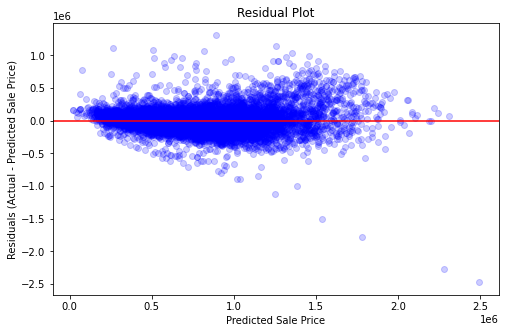

In [245]:
get_resid(preprocessed6, model6)

C:\Users\Andrew\Documents\Flatiron\Course\phase_2\project\110920-pt-phase-2-project\useful_functions.py:66: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


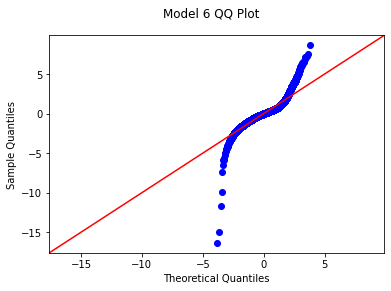

In [246]:
get_qq(model6, 'Model 6')

In [242]:
X_int6 = sm.add_constant(X_train6)
model6 = sm.OLS(y_train6, X_int6).fit()
model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     474.0
Date:                Thu, 04 Mar 2021   Prob (F-statistic):               0.00
Time:                        23:48:23   Log-Likelihood:            -1.9993e+05
No. Observations:               14980   AIC:                         4.001e+05
Df Residuals:                   14840   BIC:                         4.012e+05
Df Model:                         139                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -9.809e+05   8.22e+06     -0.119      0.905   -1.71e+07    1.51e+07
AdjacentGreenbelt    -2184.8460   8457.549     -0.258      0.796   -1.88e+04    1.44e+04
excellent_view        1.383e+05   1.36e+04     10.140      0.000    1.12e+05    1.65e+05
Topography           -1.224e+04   4986.125     -2.455      0.014    -2.2e+04   -2469.078
InadequateParking    -8996.6520   3240.568     -2.776      0.006   -1.53e+04   -2644.737
MtRainier            -1.718e+04   1.53e+04     -1.125      0.260   -4.71e+04    1.27e+04
Olympics              5.293e+04   1.14e+04      4.625      0.000    3.05e+04    7.54e+04
Cascades              8032.4087   9406.227      0.854      0.393   -1.04e+04    2.65e+04
Territorial          -2587.3475   6586.966     -0.393      0.694   -1.55e+04    1.03e+04
SeattleSkyline        9.377e+04   1.52e+04      6.171      0.000     6.4e+04    1.24e+05
PugetSound            7.019e+04   1.04e+04      6.769      0.000    4.99e+04    9.05e+04
LakeWashington         1.65e+05   1.01e+04     16.292      0.000    1.45e+05    1.85e+05
LakeSammamish         1.684e+05    2.1e+04      8.018      0.000    1.27e+05     2.1e+05
SmallLakeRiverCreek  -3.776e+04   1.87e+04     -2.015      0.044   -7.45e+04   -1031.098
OtherView            -4.678e+04   2.26e+04     -2.071      0.038   -9.11e+04   -2509.884
WfntLocation          2.624e+05   1.71e+04     15.316      0.000    2.29e+05    2.96e+05
Easements             2.551e+04   9495.370      2.687      0.007    6899.282    4.41e+04
SaleWarning          -1.068e+05   5316.260    -20.086      0.000   -1.17e+05   -9.64e+04
ViewUtilization        7.53e+04      1e+04      7.496      0.000    5.56e+04     9.5e+04
has_porch             2.133e+04   2690.030      7.931      0.000    1.61e+04    2.66e+04
has_renovation            7e+04   6037.834     11.594      0.000    5.82e+04    8.18e+04
has_basement          -1.51e+04   3161.615     -4.775      0.000   -2.13e+04   -8899.337
TrafficNoise         -3.291e+04   3682.486     -8.936      0.000   -4.01e+04   -2.57e+04
has_problem          -2.255e+04   6591.810     -3.421      0.001   -3.55e+04   -9627.776
SqFtTotLiving          156.0752      3.408     45.792      0.000     149.394     162.756
SqFt1stFloor            14.1965      4.744      2.992      0.003       4.897      23.496
latitude               1.31e+05   6.79e+04      1.929      0.054   -2106.945    2.64e+05
longitude             3.687e+04   6.43e+04      0.574      0.566   -8.91e+04    1.63e+05
dist_to_exp          -9278.2377    852.469    -10.884      0.000   -1.09e+04   -7607.293
age                    281.0426     72.975      3.851      0.000     138.003     424.082
x0_Floor-Wall        -1886.9287   9002.708     -0.210      0.834   -1.95e+04    1.58e+04
x0_Forced Air         2737.4482   6495.512      0.421    

In [243]:
# I will now check run the model using sk-learn
linreg = LinearRegression()

# Fit on training data
linreg6 = linreg.fit(X_train6, y_train6)

scores6 = cross_val_score(
            linreg6, 
            X_train6,
            y_train6,
            cv=10,
            scoring="neg_mean_squared_error"
)

rmse_scores6 = np.sqrt(-scores6)
display(rmse_scores6)
display(rmse_scores6.mean())
display(rmse_scores6.std())

array([187165.76612223,  95201.47920293,  92223.77021711, 105275.92555318,
       125961.47105437, 122146.37209557, 128926.18138758, 141953.59817183,
       158452.64936749, 512208.35599718])

166951.55691694707

118312.22299791012

In [244]:
summary.loc[5] = ['Multiple Linear Model 4', 'continuous + binary features + cat', model6.df_model, round(model6.rsquared,3)\
                  , round(model6.rsquared_adj,3), int(rmse_scores6.mean()), int(rmse_scores6.std()),\
                  round((sms.jarque_bera(model6.resid)[0]),0)]

summary

Model  \
0  Simple Model - one independent variable   
1          Simple Model - outliers removed   
2                  Multiple Linear Model 1   
3                  Multiple Linear Model 2   
4                  Multiple Linear Model 3   
5                  Multiple Linear Model 4   

                             Description   No. Features    R^2  Adj R^2  \
0                 Square ft Total living            1.0  0.389    0.389   
1                 Square ft Total living            1.0  0.354    0.354   
2                    Continuous features            4.0  0.535    0.535   
3  Continuous features + age/dist_to_exp            6.0  0.567    0.566   
4           continuous + binary features           29.0  0.622    0.622   
5     continuous + binary features + cat          139.0  0.816    0.814   

       RMSE   RMSE sd         JB  
0  398611.0  342506.0  9825842.0  
1  294579.0  168991.0     7132.0  
2  238663.0  158954.0    18348.0  
3  236962.0  153473.0    16023.0  
4  227275.0  146517.0    16416.0  
5  166951.0  118312.0   165256.0

The JB metric on this model has increased by an order of magnitude and its clear from the qq plot that the normality of residuals assumption is not being met, there could also be strong multicollinearity at play. I will work to try and improve this model both in terms of R^2 but more importantly the JB number to provide confidence in the results. 

In [248]:
# check for highly correlated features
get_multicol(preprocessed6)

cc
pairs                            
(x2_PUBLIC, x2_PRIVATE)  0.985493
(x4_4, x4_3)             0.748812

Ok so two dummy variables are highly correlated, this would lead me to suspect the variable being dropped when onehotencoding has a relatively low count. It may be worse removing these rows from the analysis for the next model. 

In [249]:
get_multicol(df6)

cc
pairs                                        
(age, YrBuilt)                       1.000000
(has_renovation, YrRenovated)        0.999959
(latitude, Township)                 0.984267
(has_basement, SqFtTotBasement)      0.882418
(OtherNuisances, has_problem)        0.846419
(FinBasementGrade, SqFtFinBasement)  0.845789
(SqFtFinBasement, SqFtTotBasement)   0.837436
(Stories, SqFt2ndFloor)              0.824724
(has_basement, FinBasementGrade)     0.822696
(SqFtTotBasement, FinBasementGrade)  0.811965
(SqFtTotLiving, BldgGrade)           0.715628
(SqFtFinBasement, has_basement)      0.702382

# Model 7 - Cleaning features, adding SqFt2ndFloor

In [274]:
df7 = df6.copy()

In [275]:
df7.Condition.value_counts()

3    8487
4    4497
5    1862
2     119
1      15
Name: Condition, dtype: int64

In [276]:
df7.Access.value_counts()

PUBLIC               14096
PRIVATE                860
RESTRICTED              11
WALK IN                 11
LEGAL/UNDEVELOPED        2
Name: Access, dtype: int64

I will drop rows containing 1 and 2 in 'Condition' and keep only PUBLIC and PRIVATE in Access to try and reduce multicollinearity

In [277]:
df7 = df7[(df7['Condition']==3)|(df7['Condition']==4)|(df7['Condition']==5)]
df7 = df7[(df7['Access']=='PUBLIC')|(df7['Access']=='PRIVATE')]

In [278]:
df7.Condition.value_counts()

3    8475
4    4489
5    1858
Name: Condition, dtype: int64

In [279]:
df7.Access.value_counts()

PUBLIC     13970
PRIVATE      852
Name: Access, dtype: int64

In [280]:
# check other categorical features for such imbalances
df7.Bedrooms.value_counts()

3     6784
4     4834
2     1801
5     1091
6      142
1      137
0       14
7       13
8        4
9        1
10       1
Name: Bedrooms, dtype: int64

In [281]:
# remove high and low values
df7 = df7[(df7['Bedrooms']>1)&(df7['Bedrooms']<7)]

In [282]:
df7.Bedrooms.value_counts()

3    6784
4    4834
2    1801
5    1091
6     142
Name: Bedrooms, dtype: int64

In [283]:
df7.HeatSource.value_counts()

Gas                  10348
Electricity           2578
Oil                   1676
Gas/Solar               30
Other                    9
Electricity/Solar        8
Oil/Solar                3
Name: HeatSource, dtype: int64

In [284]:
# remove low number entries
df7 = df7[(df7['HeatSource']=='Gas')|(df7['HeatSource']=='Electricity')|(df7['HeatSource']=='Oil')]

In [285]:
df7.HeatSource.value_counts()

Gas            10348
Electricity     2578
Oil             1676
Name: HeatSource, dtype: int64

In [288]:
# add SqFt2ndFloor
features_7 = ['AdjacentGreenbelt', 'excellent_view', 'Topography', 'InadequateParking', 'MtRainier', 'Olympics', 'Cascades',\
               'Territorial', 'SeattleSkyline', 'PugetSound', 'LakeWashington', 'LakeSammamish', 'SmallLakeRiverCreek',\
               'OtherView', 'WfntLocation', 'Easements', 'SaleWarning', 'ViewUtilization', 'has_porch', 'has_renovation',\
              'has_basement', 'TrafficNoise', 'has_problem', 'SqFtTotLiving', 'SqFt1stFloor', 'latitude', 'longitude',\
               'dist_to_exp', 'age', 'SalePrice', 'SqFt2ndFloor']
categoricals7 = ['HeatSystem', 'HeatSource', 'Access', 'ZipCode', 'Condition', 'Bedrooms', 'BldgGrade']

In [289]:
cat7_ohe = df7[categoricals7]
encoder = OneHotEncoder(drop='first', sparse=False)
encoder7 = encoder.fit(cat7_ohe)
cat7_ohe = encoder7.transform(cat7_ohe)
cat7_ohe = pd.DataFrame(cat7_ohe, columns = encoder7.get_feature_names())
cont7 = df7[features_7]
cat7_ohe.reset_index(drop=True, inplace=True)
cont7.reset_index(drop=True, inplace=True)
preprocessed7 = pd.concat([cont7, cat7_ohe], axis=1)
X_train7 = preprocessed7.drop('SalePrice', axis=1)
y_train7 = preprocessed7['SalePrice']

In [290]:
X_int7 = sm.add_constant(X_train7)
model7 = sm.OLS(y_train7, X_int7).fit()
model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     547.0
Date:                Fri, 05 Mar 2021   Prob (F-statistic):               0.00
Time:                        00:40:31   Log-Likelihood:            -1.9462e+05
No. Observations:               14602   AIC:                         3.895e+05
Df Residuals:                   14478   BIC:                         3.904e+05
Df Model:                         123                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -4.362e+05   8.21e+06     -0.053      0.958   -1.65e+07    1.57e+07
AdjacentGreenbelt   -4369.1973   8335.863     -0.524      0.600   -2.07e+04     1.2e+04
excellent_view       1.517e+05   1.38e+04     10.979      0.000    1.25e+05    1.79e+05
Topography          -1.149e+04   4996.727     -2.300      0.021   -2.13e+04   -1698.574
InadequateParking   -9172.6588   3221.223     -2.848      0.004   -1.55e+04   -2858.650
MtRainier           -1.132e+04   1.52e+04     -0.742      0.458   -4.12e+04    1.86e+04
Olympics             5.474e+04   1.14e+04      4.787      0.000    3.23e+04    7.72e+04
Cascades             2947.6465   9365.017      0.315      0.753   -1.54e+04    2.13e+04
Territorial         -2506.7665   6563.092     -0.382      0.703   -1.54e+04    1.04e+04
SeattleSkyline       9.543e+04    1.5e+04      6.382      0.000    6.61e+04    1.25e+05
PugetSound           6.968e+04   1.03e+04      6.738      0.000    4.94e+04       9e+04
LakeWashington       1.723e+05   1.01e+04     17.063      0.000    1.53e+05    1.92e+05
LakeSammamish         1.74e+05   2.07e+04      8.421      0.000    1.33e+05    2.14e+05
SmallLakeRiverCreek -3.179e+04   1.92e+04     -1.660      0.097   -6.93e+04    5753.859
OtherView           -6.663e+04   2.26e+04     -2.945      0.003   -1.11e+05   -2.23e+04
WfntLocation         2.653e+05   1.75e+04     15.122      0.000    2.31e+05       3e+05
Easements            2.339e+04   9470.408      2.470      0.014    4825.640     4.2e+04
SaleWarning         -1.115e+05   5369.529    -20.774      0.000   -1.22e+05   -1.01e+05
ViewUtilization      7.205e+04   9961.204      7.233      0.000    5.25e+04    9.16e+04
has_porch            1.847e+04   2694.022      6.857      0.000    1.32e+04    2.38e+04
has_renovation        6.61e+04   6030.647     10.960      0.000    5.43e+04    7.79e+04
has_basement         2378.1533   3893.550      0.611      0.541   -5253.702       1e+04
TrafficNoise        -3.168e+04   3672.715     -8.626      0.000   -3.89e+04   -2.45e+04
has_problem         -2.215e+04   6639.626     -3.336      0.001   -3.52e+04   -9134.841
SqFtTotLiving         134.6169      4.423     30.435      0.000     125.947     143.287
SqFt1stFloor           43.6443      5.999      7.275      0.000      31.885      55.404
latitude             1.345e+05   6.76e+04      1.988      0.047    1892.531    2.67e+05
longitude            4.746e+04   6.42e+04      0.740      0.459   -7.83e+04    1.73e+05
dist_to_exp         -9339.6238    847.119    -11.025      0.000    -1.1e+04   -7679.161
age                   466.1618     73.888      6.309      0.000     321.333     610.991
SqFt2ndFloor           38.6101      4.793      8.056      0.000      29.216      48.004
x0_Floor-Wall       -6714.2314   9198.508     -0.730      0.465   -2.47e+04    1.13e+04
x0_

In [291]:
# I will now check run the model using sk-learn
linreg = LinearRegression()

# Fit on training data
linreg7 = linreg.fit(X_train7, y_train7)

scores7 = cross_val_score(
            linreg7, 
            X_train7,
            y_train7,
            cv=10,
            scoring="neg_mean_squared_error"
)

rmse_scores7 = np.sqrt(-scores7)
display(rmse_scores7)
display(rmse_scores7.mean())
display(rmse_scores7.std())

array([185478.31155742,  92977.26615748,  90360.84457932, 104889.50489757,
       123299.89058647, 120816.71510651, 126734.21751375, 139383.6105672 ,
       153720.09360283, 511661.9363623 ])

164932.23909308625

118703.0456134486

In [292]:
summary.loc[6] = ['Multiple Linear Model 5', 'MLP 4 + SqFt2nd + Clean Cat', model7.df_model, round(model7.rsquared,3)\
                  , round(model7.rsquared_adj,3), int(rmse_scores7.mean()), int(rmse_scores7.std()),\
                  round((sms.jarque_bera(model7.resid)[0]),0)]

summary

Model  \
0  Simple Model - one independent variable   
1          Simple Model - outliers removed   
2                  Multiple Linear Model 1   
3                  Multiple Linear Model 2   
4                  Multiple Linear Model 3   
5                  Multiple Linear Model 4   
6                  Multiple Linear Model 5   

                             Description   No. Features    R^2  Adj R^2  \
0                 Square ft Total living            1.0  0.389    0.389   
1                 Square ft Total living            1.0  0.354    0.354   
2                    Continuous features            4.0  0.535    0.535   
3  Continuous features + age/dist_to_exp            6.0  0.567    0.566   
4           continuous + binary features           29.0  0.622    0.622   
5     continuous + binary features + cat          139.0  0.816    0.814   
6            MLP 4 + SqFt2nd + Clean Cat          123.0  0.823    0.821   

       RMSE   RMSE sd         JB  
0  398611.0  342506.0  9825842.0  
1  294579.0  168991.0     7132.0  
2  238663.0  158954.0    18348.0  
3  236962.0  153473.0    16023.0  
4  227275.0  146517.0    16416.0  
5  166951.0  118312.0   165256.0  
6  164932.0  118703.0   206712.0

By reducing the number of features, we actually managed to improve the R-squared, which is perhaps and indication that the features that were dropped were causing problems. However, the JB number is still high. Another pass of outliers may be required.

Longitude has been a persistent bad actor, again this is worth investigating further

In [294]:
df7.HeatSystem.value_counts()

Forced Air    11710
Elec BB         986
Heat Pump       974
Floor-Wall      420
Hot Water       320
Radiant         152
Gravity          36
Other             4
Name: HeatSystem, dtype: int64

It was noted that the majority of the dummy variables pertaining to the Heat System column had high P-values. It might be worth making this a binary column, either forced air or not. I will create a new column for this rather than lose the data here. 

In [295]:
df7.SalePrice.describe()

count    1.460200e+04
mean     7.077948e+05
std      3.533408e+05
min      1.000000e+01
25%      4.500000e+05
50%      6.300000e+05
75%      8.520000e+05
max      2.450000e+06
Name: SalePrice, dtype: float64

A very large spread on this, but interestingly some low values that I am keen to investigate more. 

In [298]:
df7[df7['SalePrice']< 100000].sort_values('SalePrice')

Address  BuildingNumber DirectionPrefix  \
0       17701   185TH AVE NE  98072           17701                   
1        9508   167TH AVE NE  98052            9508                   
2        19361   61ST AVE NE  98028           19361                   
3      15915   VASHON HWY SW  98070           15915                   
5        19501   61ST AVE NE  98028           19501                   
6   10649  SW CEDARHURST RD   98070           10649              SW   
7        3237   110TH AVE SE  98004            3237                   
9          6837  S 124TH ST   98178            6837              S    
10       19632   62ND AVE NE  98028           19632                   
12       17658  SE 240TH ST   98042           17658              SE   
13       18203  SE 272ND ST   98042           18203              SE   
14      18626   175TH AVE SE  98058           18626                   
15       30645   26TH AVE SW  98023           30645                   
16        10831  SE LAKE RD   98004           10831              SE   
17        11065  SE LAKE RD   98004           11065              SE   
18        3425   97TH AVE SE  98040            3425                   
19       25320   120TH PL SE  98030           25320                   
20       17721   113TH PL SE  98055           17721                   
21        6808  NE 165TH ST   98028            6808              NE   
22       18203  SE 272ND ST   98042           18203              SE   
23        7444  NE 146TH ST   98028            7444              NE   
24        2215   44TH AVE SW  98116            2215                   
27         5131  S 324TH ST   98001            5131              S    
28      26636   188TH AVE SE  98042           26636                   
29        21058   98TH AVE S  98031           21058                   
32        8709   14TH AVE NW  98117            8709                   
33         7045  S 125TH ST   98178            7045              S    

                   StreetName StreetType DirectionSuffix ZipCode  Stories  \
0   185TH                         AVE                 NE   98072      1.0   
1   167TH                         AVE                 NE   98052      1.0   
2   61ST                          AVE                 NE   98028      2.0   
3   VASHON                        HWY                 SW   98070      1.0   
5   61ST                          AVE                 NE   98028      1.0   
6   CEDARHURST                    RD                       98070      2.0   
7   110TH                         AVE                 SE   98004      3.0   
9   124TH                         ST                       98178      1.0   
10  62ND                          AVE                 NE   98028      1.0   
12  240TH                         ST                       98042      1.0   
13  272ND                         ST                       98042      1.5   
14  175TH                         AVE                 SE   98058      2.0   
15  26TH                          AVE                 SW   98023      1.0   
16  LAKE                          RD                       98004      2.0   
17  LAKE                          RD                       98004      2.0   
18  97TH                          AVE                 SE   98040      2.0   
19  120TH                         PL                  SE   98030      1.0   
20  113TH                         PL                  SE   98055      1.0   
21  165TH                         ST                       98028      1.0   
22  272ND                         ST                       98042      1.5   
23  146TH                         ST                       98028      1.0   
24  44TH                          AVE                 SW   98116      1.0   
27  324TH                         ST                       98001      2.0   
28  188TH                         AVE                 SE   98042      1.0   
29  98TH                          AVE                 S    98031      1.0   
32  14TH                          AVE

There are several properties in sought  after areas (Mercer Island, Bellevue) that have clearly had the wrong price entered.
I will remove these for the next model.

In [299]:
df7.describe()

BuildingNumber       Stories     BldgGrade  SqFt1stFloor  \
count    14602.000000  14602.000000  14602.000000  14602.000000   
mean     10789.922202      1.424702      7.517532   1246.618956   
std       9420.323006      0.501587      1.027597    389.750327   
min          6.000000      1.000000      5.000000     50.000000   
25%       2818.000000      1.000000      7.000000    980.000000   
50%       8410.000000      1.000000      7.000000   1210.000000   
75%      16519.000000      2.000000      8.000000   1460.000000   
max      48617.000000      3.000000     12.000000   2560.000000   

       SqFtHalfFloor  SqFt2ndFloor  SqFtUpperFloor  SqFtTotLiving  \
count   14602.000000  14602.000000    14602.000000   14602.000000   
mean       49.453910    388.716683        6.953773    1996.445487   
std       169.907707    570.707007       66.428104     761.526937   
min         0.000000      0.000000        0.000000     402.000000   
25%         0.000000      0.000000        0.000000    1420.000000   
50%         0.000000      0.000000        0.000000    1890.000000   
75%         0.000000    830.000000        0.000000    2440.000000   
max      1930.000000   2600.000000     1800.000000    4620.000000   

       SqFtTotBasement  SqFtFinBasement  FinBasementGrade  SqFtGarageBasement  \
count     14602.000000     14602.000000      14602.000000        14602.000000   
mean        495.817011       305.906931          2.878578           84.081153   
std         563.799068       434.161724          3.490060          176.767700   
min           0.000000         0.000000          0.000000            0.000000   
25%           0.000000         0.000000          0.000000            0.000000   
50%           0.000000         0.000000          0.000000            0.000000   
75%         990.000000       600.000000          7.000000            0.000000   
max        2580.000000      2170.000000         11.000000         1360.000000   

       SqFtGarageAttached  DaylightBasement  SqFtOpenPorch  SqFtEnclosedPorch  \
count        14602.000000      14602.000000   14602.000000       14602.000000   
mean           249.184427          0.269689      56.400767           5.344405   
std            275.202454          0.443813      97.080682          32.887119   
min              0.000000          0.000000       0.000000           0.000000   
25%              0.000000          0.000000       0.000000           0.000000   
50%            180.000000          0.000000       0.000000           0.000000   
75%            470.000000          1.000000      80.000000           0.000000   
max           2248.000000          1.000000    1380.000000         780.000000   

           SqFtDeck    BrickStone  ViewUtilization      Bedrooms  \
count  14602.000000  14602.000000     14602.000000  14602.000000   
mean     135.469182      3.914464         0.018970      3.385358   
std      204.054262     17.728102         0.136424      0.830823   
min        0.000000      0.000000         0.000000      2.000000   
25%        0.000000      0.000000         0.000000      3.000000   
50%        0.000000      0.000000         0.000000      3.000000   
75%      210.000000      0.000000         0.000000      4.000000   
max     2250.000000    100.000000         1.000000      6.000000   

       BathHalfCount  Bath3qtrCount  BathFullCount       YrBuilt  \
count   14602.000000   14602.000000   14602.000000  14602.000000   
mean        0.436242       0.497466       1.485413   1968.367073   
std         0.514374       0.623293       0.624226     27.967550   
min         0.000000       0.000000       0.000000   1900.000000   
25%         0.000000       0.000000       1.000000   1950.000000   
50%         0.000000       0.000000       1.000000   1969.000000   
75%         1.000000       1.000000       2.000000   1990.000000   
max         3.000000       5.000000       5.000000   2020.000000   

        YrRenovated     Condition            id      Township       Section  \
count  14602.000

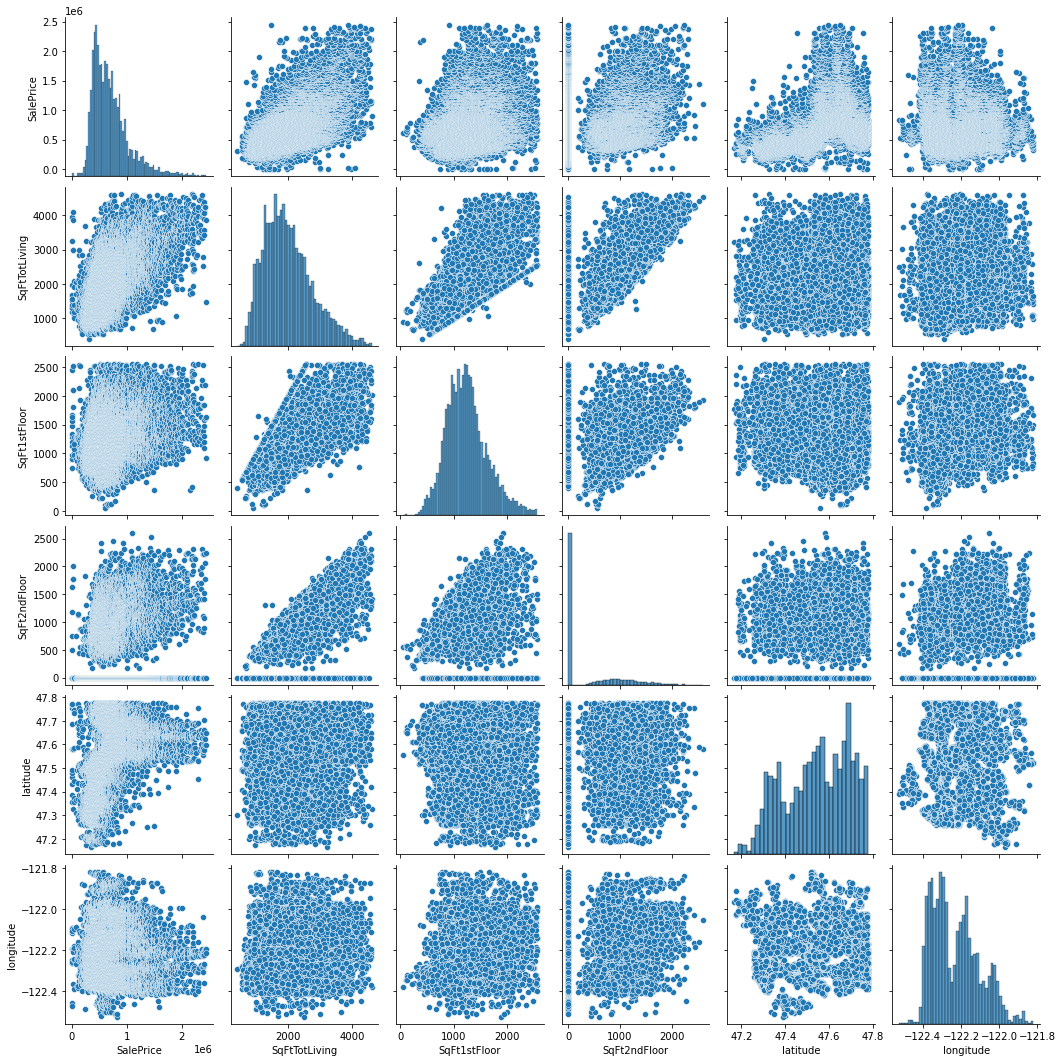

In [301]:
cont_pairplot7 = ['SalePrice','SqFtTotLiving','SqFt1stFloor','SqFt2ndFloor', 'latitude', 'longitude']
sns.pairplot(df7[cont_pairplot7])

Looking at this I am not convinced by longitude, it is not linear. I will remove it from the next model.

# Model 8 - More outlier removal, drop longitude

In [302]:
df8 = df7.copy()

In [303]:
# get rid of low and probably erroneous home values - I could replace with average home value but few rows impacted only
df8 = df8[df8['SalePrice']> 75000]

# creating category for heat system type
df8['heating'] = 0
df8.loc[(df8['HeatSystem'] == 'Forced Air'),'heating'] = 1

In [309]:
df8[df8.SqFt1stFloor<300]

Address  BuildingNumber DirectionPrefix  \
1595       3863   21ST AVE SW  98106            3863                   
4894        819 B NW 97TH ST   98117             819              NW   
5681        1116 A  13TH AVE   98122            1116                   
5935        1116 B  13TH AVE   98122            1116                   
7145     4262 A  WINSLOW PL N  98103            4262                   
7150     3905 C SW HUDSON ST   98116            3905              SW   
7771        6342   5TH AVE NE  98115            6342                   
8013    3636 C  WHITMAN AVE N  98103            3636                   
8613   4414 A  MERIDIAN AVE N  98103            4414                   
9227         921 C N 35TH ST   98103             921              N    
10375       7407   4TH AVE NE  98115            7407                   

                      StreetName StreetType DirectionSuffix ZipCode  Stories  \
1595   21ST                          AVE                 SW   98106      2.0   
4894   97TH                          ST                       98117      3.0   
5681   13TH                          AVE                      98122      3.0   
5935   13TH                          AVE                      98122      3.0   
7145   WINSLOW                       PL                  N    98103      3.0   
7150   HUDSON                        ST                       98116      2.0   
7771   5TH                           AVE                 NE   98115      3.0   
8013   WHITMAN                       AVE                 N    98103      3.0   
8613   MERIDIAN                      AVE                 N    98103      3.0   
9227   35TH                          ST                       98103      3.0   
10375  4TH                           AVE                 NE   98115      3.0   

       BldgGrade  SqFt1stFloor  SqFtHalfFloor  SqFt2ndFloor  SqFtUpperFloor  \
1595           6           260              0           180               0   
4894           8           220              0           610             610   
5681           8           220              0           230             230   
5935           8           230              0           210             210   
7145           8           110              0           550             550   
7150           8            50              0           550               0   
7771           7           130              0           370             370   
8013           8           110              0           570             570   
8613           7           120              0           530             530   
9227           8           120              0           570             570   
10375          7           180              0           520             520   

       SqFtTotLiving  SqFtTotBasement  SqFtFinBasement  FinBasementGrade  \
1595             670              230              230                 6   
4894            1440                0                0                 0   
5681             680                0                0                 0   
5935             650                0                0                 0   
7145            1210                0                0                 0   
7150             890              290              290                 8   
7771             870                0                0                 0   
8013            1250                0                0                 0   
8613            1180                0                0                 0   
9227            1260                0                0                 0   
10375           1220                0                0                 0   

       SqFtGarageBasement  SqFtGarageAttached  DaylightBasement  \
1595                    0                   0                 1   
4894                    0                 250                 0   
5681                    0                   0                 0   
5935                    0                   0                 0   
7145  

In [312]:
# get rid of the outliers in the 1st floor category on the low side, they maybe represent stairways or entrance halls.
# setting these first floor values to their second floor equivalents
df8.loc[df8.SqFt1stFloor<300, 'SqFt1stFloor'] = df8['SqFt2ndFloor']

In [314]:
# remove longitude, add new heating feature, remove heatsystem from categoricals
features_8 = ['AdjacentGreenbelt', 'excellent_view', 'Topography', 'InadequateParking', 'MtRainier', 'Olympics', 'Cascades',\
               'Territorial', 'SeattleSkyline', 'PugetSound', 'LakeWashington', 'LakeSammamish', 'SmallLakeRiverCreek',\
               'OtherView', 'WfntLocation', 'Easements', 'SaleWarning', 'ViewUtilization', 'has_porch', 'has_renovation',\
              'has_basement', 'TrafficNoise', 'has_problem', 'SqFtTotLiving', 'SqFt1stFloor', 'latitude',\
               'dist_to_exp', 'age', 'SalePrice', 'SqFt2ndFloor', 'heating']
categoricals8 = ['HeatSource', 'Access', 'ZipCode', 'Condition', 'Bedrooms', 'BldgGrade']

In [315]:
cat8_ohe = df8[categoricals8]
encoder = OneHotEncoder(drop='first', sparse=False)
encoder8 = encoder.fit(cat8_ohe)
cat8_ohe = encoder8.transform(cat8_ohe)
cat8_ohe = pd.DataFrame(cat8_ohe, columns = encoder8.get_feature_names())
cont8 = df8[features_8]
cat8_ohe.reset_index(drop=True, inplace=True)
cont8.reset_index(drop=True, inplace=True)
preprocessed8 = pd.concat([cont8, cat8_ohe], axis=1)
X_train8 = preprocessed8.drop('SalePrice', axis=1)
y_train8 = preprocessed8['SalePrice']

In [316]:
X_int8 = sm.add_constant(X_train8)
model8 = sm.OLS(y_train8, X_int8).fit()
model8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     626.6
Date:                Fri, 05 Mar 2021   Prob (F-statistic):               0.00
Time:                        01:27:20   Log-Likelihood:            -1.9383e+05
No. Observations:               14580   AIC:                         3.879e+05
Df Residuals:                   14463   BIC:                         3.888e+05
Df Model:                         116                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -5.206e+06   3.08e+06     -1.689      0.091   -1.12e+07    8.35e+05
AdjacentGreenbelt   -3045.3908   8060.412     -0.378      0.706   -1.88e+04    1.28e+04
excellent_view       1.677e+05   1.34e+04     12.548      0.000    1.41e+05    1.94e+05
Topography          -1.501e+04   4825.710     -3.111      0.002   -2.45e+04   -5555.549
InadequateParking   -8750.2101   3110.347     -2.813      0.005   -1.48e+04   -2653.532
MtRainier            3.584e+04   1.48e+04      2.414      0.016    6741.577    6.49e+04
Olympics             5.356e+04   1.11e+04      4.847      0.000    3.19e+04    7.52e+04
Cascades            -6383.2312   9031.830     -0.707      0.480   -2.41e+04    1.13e+04
Territorial          -206.6545   6343.592     -0.033      0.974   -1.26e+04    1.22e+04
SeattleSkyline       8.627e+04   1.44e+04      5.975      0.000     5.8e+04    1.15e+05
PugetSound           6.242e+04   9990.013      6.248      0.000    4.28e+04     8.2e+04
LakeWashington       1.849e+05   9765.566     18.934      0.000    1.66e+05    2.04e+05
LakeSammamish         1.71e+05   1.99e+04      8.574      0.000    1.32e+05     2.1e+05
SmallLakeRiverCreek  -6.46e+04   1.85e+04     -3.486      0.000   -1.01e+05   -2.83e+04
OtherView           -7.637e+04   2.19e+04     -3.495      0.000   -1.19e+05   -3.35e+04
WfntLocation         3.122e+05    1.7e+04     18.344      0.000    2.79e+05    3.46e+05
Easements             2.37e+04   9141.382      2.593      0.010    5785.352    4.16e+04
SaleWarning         -9.838e+04   5228.691    -18.814      0.000   -1.09e+05   -8.81e+04
ViewUtilization      7.317e+04   9607.614      7.616      0.000    5.43e+04     9.2e+04
has_porch            1.834e+04   2600.589      7.052      0.000    1.32e+04    2.34e+04
has_renovation       6.816e+04   5823.667     11.704      0.000    5.67e+04    7.96e+04
has_basement         5675.3354   3758.960      1.510      0.131   -1692.707     1.3e+04
TrafficNoise        -2.705e+04   3552.205     -7.614      0.000    -3.4e+04   -2.01e+04
has_problem         -1.922e+04   6422.765     -2.993      0.003   -3.18e+04   -6631.835
SqFtTotLiving         131.4450      4.277     30.730      0.000     123.061     139.829
SqFt1stFloor           51.6644      5.813      8.888      0.000      40.270      63.059
latitude             1.124e+05   6.51e+04      1.727      0.084   -1.52e+04     2.4e+05
dist_to_exp         -9236.0106    783.106    -11.794      0.000   -1.08e+04   -7701.022
age                   449.3869     70.680      6.358      0.000     310.844     587.930
SqFt2ndFloor           46.0023      4.643      9.908      0.000      36.901      55.103
heating             -9930.1493   3700.587     -2.683      0.007   -1.72e+04   -2676.526
x0_Gas               1.306e+04   3949.175      3.307      0.001    5319.479    2.08e+04
x0_

In [317]:
# I will now check run the model using sk-learn
linreg = LinearRegression()

# Fit on training data
linreg8 = linreg.fit(X_train8, y_train8)

scores8 = cross_val_score(
            linreg8, 
            X_train8,
            y_train8,
            cv=10,
            scoring="neg_mean_squared_error"
)

rmse_scores8 = np.sqrt(-scores8)
display(rmse_scores8)
display(rmse_scores8.mean())
display(rmse_scores8.std())

array([133767.39944664,  94138.25091176,  91809.60378907, 105035.06376526,
       124450.34442038, 120530.46811026, 127213.05287854, 139894.53089821,
       157639.61180337, 488131.26009583])

158260.95861193296

111643.75578564298

In [318]:
summary.loc[7] = ['Multiple Linear Model 6', 'MLP 5 outliers longitude removed', model8.df_model, round(model8.rsquared,3)\
                  , round(model8.rsquared_adj,3), int(rmse_scores8.mean()), int(rmse_scores8.std()),\
                  round((sms.jarque_bera(model8.resid)[0]),0)]

summary

Model  \
0  Simple Model - one independent variable   
1          Simple Model - outliers removed   
2                  Multiple Linear Model 1   
3                  Multiple Linear Model 2   
4                  Multiple Linear Model 3   
5                  Multiple Linear Model 4   
6                  Multiple Linear Model 5   
7                  Multiple Linear Model 6   

                             Description   No. Features    R^2  Adj R^2  \
0                 Square ft Total living            1.0  0.389    0.389   
1                 Square ft Total living            1.0  0.354    0.354   
2                    Continuous features            4.0  0.535    0.535   
3  Continuous features + age/dist_to_exp            6.0  0.567    0.566   
4           continuous + binary features           29.0  0.622    0.622   
5     continuous + binary features + cat          139.0  0.816    0.814   
6            MLP 4 + SqFt2nd + Clean Cat          123.0  0.823    0.821   
7       MLP 5 outliers longitude removed          116.0  0.834    0.833   

       RMSE   RMSE sd         JB  
0  398611.0  342506.0  9825842.0  
1  294579.0  168991.0     7132.0  
2  238663.0  158954.0    18348.0  
3  236962.0  153473.0    16023.0  
4  227275.0  146517.0    16416.0  
5  166951.0  118312.0   165256.0  
6  164932.0  118703.0   206712.0  
7  158260.0  111643.0    32901.0

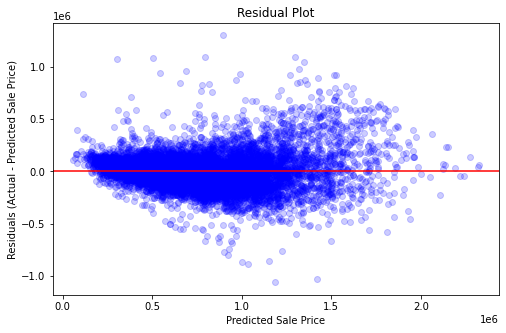

In [319]:
get_resid(preprocessed8, model8)

# Model 9 - YES I FORGOT BATHROOMS!!

In [320]:
df9 = df8.copy()

In [321]:
df9.columns

Index(['Address', 'BuildingNumber', 'DirectionPrefix', 'StreetName',
       'StreetType', 'DirectionSuffix', 'ZipCode', 'Stories', 'BldgGrade',
       'SqFt1stFloor', 'SqFtHalfFloor', 'SqFt2ndFloor', 'SqFtUpperFloor',
       'SqFtTotLiving', 'SqFtTotBasement', 'SqFtFinBasement',
       'FinBasementGrade', 'SqFtGarageBasement', 'SqFtGarageAttached',
       'DaylightBasement', 'SqFtOpenPorch', 'SqFtEnclosedPorch', 'SqFtDeck',
       'HeatSystem', 'HeatSource', 'BrickStone', 'ViewUtilization', 'Bedrooms',
       'BathHalfCount', 'Bath3qtrCount', 'BathFullCount', 'YrBuilt',
       'YrRenovated', 'Condition', 'id', 'Township', 'Section',
       'QuarterSection', 'Area', 'DistrictName', 'SqFtLot', 'Access',
       'Topography', 'InadequateParking', 'MtRainier', 'Olympics', 'Cascades',
       'Territorial', 'SeattleSkyline', 'PugetSound', 'LakeWashington',
       'LakeSammamish', 'SmallLakeRiverCreek', 'OtherView', 'WfntLocation',
       'TrafficNoise', 'PowerLines', 'OtherNuisances', 'Adjace

In [322]:
df9['bathrooms'] = df9['BathHalfCount']*0.5 + df9['Bath3qtrCount']*0.75 + df9['BathFullCount']

In [323]:
df9.bathrooms.value_counts()

2.50    3404
1.75    2444
1.00    2407
2.25    1495
2.00    1409
1.50    1006
2.75     930
3.00     492
3.50     386
3.25     376
3.75      68
4.00      54
4.25      38
0.75      35
4.50      16
1.25      12
4.75       4
5.25       2
6.25       1
5.50       1
Name: bathrooms, dtype: int64

In [324]:
df9['bedbath'] = df9.Bedrooms - df9.bathrooms

In [325]:
df9.bedbath.value_counts()

 1.50    2373
 1.00    2076
 1.25    2072
 0.50    1798
 2.00    1680
 0.75    1025
 2.25     778
 1.75     636
 0.25     492
 2.50     432
 3.00     305
 0.00     262
-0.25     157
-0.50     154
 3.25     107
 2.75      93
 3.50      49
 4.00      32
-0.75      19
 4.25      13
-1.25       8
-1.00       7
 4.50       5
 3.75       5
-1.50       2
Name: bedbath, dtype: int64

In [331]:
df9.bathbins = 0
df9.loc[(df9['bedbath'] < 1),'bathbins'] = 'less than 1'
df9.loc[(df9['bedbath'] > 0.99) & (df9['bedbath'] < 2), 'bathbins'] = '1 to 2'
df9.loc[(df9['bedbath'] > 1.99), 'bathbins'] = 'greater than 2'

In [332]:
df9.head()

Address  BuildingNumber DirectionPrefix  \
27     5131  S 324TH ST   98001            5131              S    
28  26636   188TH AVE SE  98042           26636                   
29    21058   98TH AVE S  98031           21058                   
32    8709   14TH AVE NW  98117            8709                   
33     7045  S 125TH ST   98178            7045              S    

                   StreetName StreetType DirectionSuffix ZipCode  Stories  \
27  324TH                         ST                       98001      2.0   
28  188TH                         AVE                 SE   98042      1.0   
29  98TH                          AVE                 S    98031      1.0   
32  14TH                          AVE                 NW   98117      1.5   
33  125TH                         ST                       98178      1.0   

    BldgGrade  SqFt1stFloor  SqFtHalfFloor  SqFt2ndFloor  SqFtUpperFloor  \
27          7          1290              0           751               0   
28          7           910              0             0               0   
29          7          1280              0             0               0   
32          7           870            390             0               0   
33          6          1280              0             0               0   

    SqFtTotLiving  SqFtTotBasement  SqFtFinBasement  FinBasementGrade  \
27           2041                0                0                 0   
28           1710              800              800                 7   
29           1280                0                0                 0   
32           1260                0                0                 0   
33           1280                0                0                 0   

    SqFtGarageBasement  SqFtGarageAttached  DaylightBasement  SqFtOpenPorch  \
27                   0                   0                 0              0   
28                   0                 410                 1              0   
29                   0                 260                 0              0   
32                   0                   0                 0              0   
33                   0                   0                 0             40   

    SqFtEnclosedPorch  SqFtDeck  HeatSystem   HeatSource  BrickStone  \
27                  0         0  Forced Air          Gas           0   
28                  0        40  Forced Air  Electricity           0   
29                  0         0  Forced Air          Gas           0   
32                  0        60  Forced Air          Gas           0   
33                  0         0     Elec BB  Electricity           0   

    ViewUtilization  Bedrooms  BathHalfCount  Bath3qtrCount  BathFullCount  \
27                0         3              1              0              2   
28                0         4              0              0              2   
29                0         3              1              0              1   
32                0         2              0              1              1   
33                0         4              0              0              1   

    YrBuilt  YrRenovated  Condition          id  Township  Section  \
27     1991            0          3  9262800198        21       14   
28     1977            0          3  8651442920        22       30   
29     1963            0          3  9320600120        22        7   
32     1945            0          4  7515000145        26       36   
33     1943            0          3  7689600345        23       12   

   QuarterSection  Area DistrictName  SqFtLot  Access  Topography  \
27             NW    27       AUBURN    28143  PUBLIC           0   
28             SE    86    COVINGTON     5200  PUBLIC           0   
29             NE    59         KENT     9373  PUBLIC           0   
32             SW     6      SEATTLE     3952  PUBLIC           0   
33             SW    25  KING COUNTY     7200  PUBLIC           0   

    InadequateParking  MtRainier  Olympics  Casca

In [337]:
df9['bathbins'].value_counts()

1 to 2            7157
less than 1       3924
greater than 2    3499
Name: bathbins, dtype: int64

I will experiment with these bathroom columns and see what happens to the model r-squared.

In [338]:
#add bedbath and also the bathbins 
features_9 = ['AdjacentGreenbelt', 'excellent_view', 'Topography', 'InadequateParking', 'MtRainier', 'Olympics', 'Cascades',\
               'Territorial', 'SeattleSkyline', 'PugetSound', 'LakeWashington', 'LakeSammamish', 'SmallLakeRiverCreek',\
               'OtherView', 'WfntLocation', 'Easements', 'SaleWarning', 'ViewUtilization', 'has_porch', 'has_renovation',\
              'has_basement', 'TrafficNoise', 'has_problem', 'SqFtTotLiving', 'SqFt1stFloor', 'latitude',\
               'dist_to_exp', 'age', 'SalePrice', 'SqFt2ndFloor', 'heating', 'bedbath']
categoricals9 = ['HeatSource', 'Access', 'ZipCode', 'Condition', 'Bedrooms', 'BldgGrade', 'bathbins']

In [339]:
cat9_ohe = df9[categoricals9]
encoder = OneHotEncoder(drop='first', sparse=False)
encoder9 = encoder.fit(cat9_ohe)
cat9_ohe = encoder9.transform(cat9_ohe)
cat9_ohe = pd.DataFrame(cat9_ohe, columns = encoder9.get_feature_names())
cont9 = df9[features_9]
cat9_ohe.reset_index(drop=True, inplace=True)
cont9.reset_index(drop=True, inplace=True)
preprocessed9 = pd.concat([cont9, cat9_ohe], axis=1)
X_train9 = preprocessed9.drop('SalePrice', axis=1)
y_train9 = preprocessed9['SalePrice']

In [340]:
X_int9 = sm.add_constant(X_train9)
model9 = sm.OLS(y_train9, X_int9).fit()
model9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     615.9
Date:                Fri, 05 Mar 2021   Prob (F-statistic):               0.00
Time:                        02:01:26   Log-Likelihood:            -1.9377e+05
No. Observations:               14580   AIC:                         3.878e+05
Df Residuals:                   14460   BIC:                         3.887e+05
Df Model:                         119                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -5.536e+06   3.07e+06     -1.802      0.072   -1.16e+07    4.85e+05
AdjacentGreenbelt   -3097.8335   8033.040     -0.386      0.700   -1.88e+04    1.26e+04
excellent_view       1.664e+05   1.33e+04     12.498      0.000     1.4e+05    1.93e+05
Topography          -1.531e+04   4809.043     -3.183      0.001   -2.47e+04   -5879.993
InadequateParking   -9065.1282   3099.743     -2.924      0.003   -1.51e+04   -2989.236
MtRainier             3.92e+04   1.48e+04      2.650      0.008    1.02e+04    6.82e+04
Olympics             5.445e+04    1.1e+04      4.942      0.000    3.29e+04     7.6e+04
Cascades            -5756.8749   9001.105     -0.640      0.522   -2.34e+04    1.19e+04
Territorial           125.7458   6321.641      0.020      0.984   -1.23e+04    1.25e+04
SeattleSkyline       8.559e+04   1.44e+04      5.948      0.000    5.74e+04    1.14e+05
PugetSound            6.27e+04   9961.320      6.294      0.000    4.32e+04    8.22e+04
LakeWashington       1.844e+05   9731.933     18.951      0.000    1.65e+05    2.04e+05
LakeSammamish        1.732e+05   1.99e+04      8.711      0.000    1.34e+05    2.12e+05
SmallLakeRiverCreek -6.331e+04   1.85e+04     -3.428      0.001   -9.95e+04   -2.71e+04
OtherView           -7.369e+04   2.18e+04     -3.384      0.001   -1.16e+05    -3.1e+04
WfntLocation         3.102e+05    1.7e+04     18.283      0.000    2.77e+05    3.43e+05
Easements            2.426e+04   9111.200      2.662      0.008    6398.465    4.21e+04
SaleWarning         -9.787e+04   5211.346    -18.780      0.000   -1.08e+05   -8.77e+04
ViewUtilization      7.187e+04   9576.883      7.504      0.000    5.31e+04    9.06e+04
has_porch            1.756e+04   2592.851      6.772      0.000    1.25e+04    2.26e+04
has_renovation       5.822e+04   5896.189      9.874      0.000    4.67e+04    6.98e+04
has_basement         1251.6479   3779.429      0.331      0.741   -6156.516    8659.812
TrafficNoise         -2.68e+04   3539.909     -7.570      0.000   -3.37e+04   -1.99e+04
has_problem         -1.896e+04   6401.346     -2.962      0.003   -3.15e+04   -6411.455
SqFtTotLiving         119.0178      4.448     26.756      0.000     110.299     127.737
SqFt1stFloor           54.1480      5.815      9.312      0.000      42.750      65.546
latitude             1.198e+05   6.49e+04      1.847      0.065   -7360.641    2.47e+05
dist_to_exp         -9082.1755    780.570    -11.635      0.000   -1.06e+04   -7552.158
age                   676.7012     74.313      9.106      0.000     531.039     822.364
SqFt2ndFloor           42.3421      4.652      9.102      0.000      33.223      51.461
heating             -9916.0852   3691.002     -2.687      0.007   -1.72e+04   -2681.249
bedbath             -2.942e+04   4841.220     -6.078      0.000   -3.89e+04   -1.99e+04
x0_

In [341]:
# I will now check run the model using sk-learn
linreg = LinearRegression()

# Fit on training data
linreg9 = linreg.fit(X_train9, y_train9)

scores9 = cross_val_score(
            linreg9, 
            X_train9,
            y_train9,
            cv=10,
            scoring="neg_mean_squared_error"
)

rmse_scores9 = np.sqrt(-scores9)
display(rmse_scores9)
display(rmse_scores9.mean())
display(rmse_scores9.std())

array([136573.23762428,  93079.72262869,  91286.49380499, 104015.10493912,
       123038.27338939, 120142.12373929, 126693.01194217, 139849.26307899,
       157474.38517063, 486903.20605155])

157905.4822369088

111436.72335630671

In [342]:
summary.loc[8] = ['Multiple Linear Model 7', 'MLP 6 + bathrooms', model9.df_model, round(model9.rsquared,3)\
                  , round(model9.rsquared_adj,3), int(rmse_scores9.mean()), int(rmse_scores9.std()),\
                  round((sms.jarque_bera(model9.resid)[0]),0)]

summary

Model  \
0  Simple Model - one independent variable   
1          Simple Model - outliers removed   
2                  Multiple Linear Model 1   
3                  Multiple Linear Model 2   
4                  Multiple Linear Model 3   
5                  Multiple Linear Model 4   
6                  Multiple Linear Model 5   
7                  Multiple Linear Model 6   
8                  Multiple Linear Model 7   

                             Description   No. Features    R^2  Adj R^2  \
0                 Square ft Total living            1.0  0.389    0.389   
1                 Square ft Total living            1.0  0.354    0.354   
2                    Continuous features            4.0  0.535    0.535   
3  Continuous features + age/dist_to_exp            6.0  0.567    0.566   
4           continuous + binary features           29.0  0.622    0.622   
5     continuous + binary features + cat          139.0  0.816    0.814   
6            MLP 4 + SqFt2nd + Clean Cat          123.0  0.823    0.821   
7       MLP 5 outliers longitude removed          116.0  0.834    0.833   
8                      MLP 6 + bathrooms          119.0  0.835    0.834   

       RMSE   RMSE sd         JB  
0  398611.0  342506.0  9825842.0  
1  294579.0  168991.0     7132.0  
2  238663.0  158954.0    18348.0  
3  236962.0  153473.0    16023.0  
4  227275.0  146517.0    16416.0  
5  166951.0  118312.0   165256.0  
6  164932.0  118703.0   206712.0  
7  158260.0  111643.0    32901.0  
8  157905.0  111436.0    32792.0

Still quite a high JB number, it would be preferable to reduce this if possible to try and honour normality assumption as best as possible

# Model 10 - Log SalePrice

In [343]:
df10 = df9.copy()

In [344]:
df10['SalePrice_log'] = np.log(df10['SalePrice'])

In [345]:
#replace saleprice with its log equivalent
features_10 = ['AdjacentGreenbelt', 'excellent_view', 'Topography', 'InadequateParking', 'MtRainier', 'Olympics', 'Cascades',\
               'Territorial', 'SeattleSkyline', 'PugetSound', 'LakeWashington', 'LakeSammamish', 'SmallLakeRiverCreek',\
               'OtherView', 'WfntLocation', 'Easements', 'SaleWarning', 'ViewUtilization', 'has_porch', 'has_renovation',\
              'has_basement', 'TrafficNoise', 'has_problem', 'SqFtTotLiving', 'SqFt1stFloor', 'latitude',\
               'dist_to_exp', 'age', 'SalePrice_log', 'SqFt2ndFloor', 'heating', 'bedbath']

#remove bathbins based on its significance in previous model
categoricals10 = ['HeatSource', 'Access', 'ZipCode', 'Condition', 'Bedrooms', 'BldgGrade']

In [346]:
cat10_ohe = df10[categoricals10]
encoder = OneHotEncoder(drop='first', sparse=False)
encoder10 = encoder.fit(cat10_ohe)
cat10_ohe = encoder10.transform(cat10_ohe)
cat10_ohe = pd.DataFrame(cat10_ohe, columns = encoder10.get_feature_names())
cont10 = df10[features_10]
cat10_ohe.reset_index(drop=True, inplace=True)
cont10.reset_index(drop=True, inplace=True)
preprocessed10 = pd.concat([cont10, cat10_ohe], axis=1)
X_train10 = preprocessed10.drop('SalePrice_log', axis=1)
y_train10 = preprocessed10['SalePrice_log']

In [347]:
X_int10 = sm.add_constant(X_train10)
model10 = sm.OLS(y_train10, X_int10).fit()
model10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     724.3
Date:                Fri, 05 Mar 2021   Prob (F-statistic):               0.00
Time:                        02:12:30   Log-Likelihood:                 4779.2
No. Observations:               14580   AIC:                            -9322.
Df Residuals:                   14462   BIC:                            -8427.
Df Model:                         117                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -11.1531      3.741     -2.981      0.003     -18.486      -3.820
AdjacentGreenbelt       0.0050      0.010      0.516      0.606      -0.014       0.024
excellent_view          0.1410      0.016      8.694      0.000       0.109       0.173
Topography             -0.0113      0.006     -1.921      0.055      -0.023       0.000
InadequateParking      -0.0037      0.004     -0.993      0.321      -0.011       0.004
MtRainier               0.0995      0.018      5.522      0.000       0.064       0.135
Olympics                0.0510      0.013      3.800      0.000       0.025       0.077
Cascades                0.0080      0.011      0.733      0.464      -0.013       0.030
Territorial             0.0199      0.008      2.582      0.010       0.005       0.035
SeattleSkyline          0.0439      0.018      2.504      0.012       0.010       0.078
PugetSound              0.0755      0.012      6.225      0.000       0.052       0.099
LakeWashington          0.1274      0.012     10.745      0.000       0.104       0.151
LakeSammamish           0.0987      0.024      4.074      0.000       0.051       0.146
SmallLakeRiverCreek    -0.0232      0.022     -1.031      0.302      -0.067       0.021
OtherView              -0.1246      0.027     -4.697      0.000      -0.177      -0.073
WfntLocation            0.3384      0.021     16.375      0.000       0.298       0.379
Easements               0.0284      0.011      2.556      0.011       0.007       0.050
SaleWarning            -0.2094      0.006    -32.996      0.000      -0.222      -0.197
ViewUtilization         0.0403      0.012      3.458      0.001       0.017       0.063
has_porch               0.0251      0.003      7.938      0.000       0.019       0.031
has_renovation          0.0552      0.007      7.692      0.000       0.041       0.069
has_basement            0.0261      0.005      5.666      0.000       0.017       0.035
TrafficNoise           -0.0368      0.004     -8.541      0.000      -0.045      -0.028
has_problem            -0.0305      0.008     -3.910      0.000      -0.046      -0.015
SqFtTotLiving           0.0001   5.42e-06     24.974      0.000       0.000       0.000
SqFt1stFloor          9.75e-05   7.07e-06     13.799      0.000    8.37e-05       0.000
latitude                0.4967      0.079      6.283      0.000       0.342       0.652
dist_to_exp            -0.0111      0.001    -11.717      0.000      -0.013      -0.009
age                     0.0007   9.05e-05      7.495      0.000       0.001       0.001
SqFt2ndFloor         7.186e-05   5.65e-06     12.718      0.000    6.08e-05    8.29e-05
heating                 0.0008      0.004      0.180      0.858      -0.008       0.010
bedbath                -0.0324      0.004     -8.800      0.000      -0.040      -0.025
x0_

In [348]:
# I will now check run the model using sk-learn
linreg = LinearRegression()

# Fit on training data
linreg10 = linreg.fit(X_train10, y_train10)

scores10 = cross_val_score(
            linreg10, 
            X_train10,
            y_train10,
            cv=10,
            scoring="neg_mean_squared_error"
)

rmse_scores10 = np.sqrt(-scores10)
display(rmse_scores10)
display(rmse_scores10.mean())
display(rmse_scores10.std())

array([0.36255092, 0.1377555 , 0.13631791, 0.13927964, 0.15061988,
       0.14368262, 0.14398502, 0.1601419 , 0.16553255, 0.28386607])

0.18237320082567346

0.0731371458561881

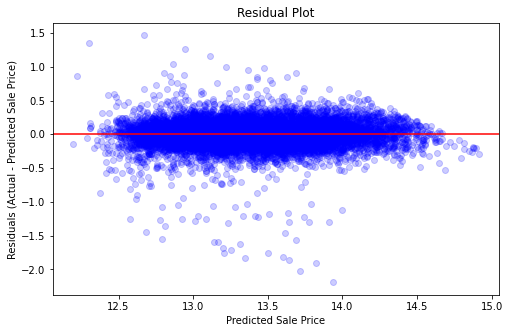

In [353]:
get_logresid(preprocessed10, model10, 'SalePrice_log')

In [371]:
summary.loc[9] = ['Multiple Linear Model 8', 'MLP 7 Log Sale Price', model10.df_model, round(model10.rsquared,3)\
                  , round(model10.rsquared_adj,3), rmse_scores10.mean(), rmse_scores10.std(),\
                  round((sms.jarque_bera(model10.resid)[0]),0)]

summary

Model  \
0  Simple Model - one independent variable   
1          Simple Model - outliers removed   
2                  Multiple Linear Model 1   
3                  Multiple Linear Model 2   
4                  Multiple Linear Model 3   
5                  Multiple Linear Model 4   
6                  Multiple Linear Model 5   
7                  Multiple Linear Model 6   
8                  Multiple Linear Model 7   
9                  Multiple Linear Model 8   

                             Description   No. Features    R^2  Adj R^2  \
0                 Square ft Total living            1.0  0.389    0.389   
1                 Square ft Total living            1.0  0.354    0.354   
2                    Continuous features            4.0  0.535    0.535   
3  Continuous features + age/dist_to_exp            6.0  0.567    0.566   
4           continuous + binary features           29.0  0.622    0.622   
5     continuous + binary features + cat          139.0  0.816    0.814   
6            MLP 4 + SqFt2nd + Clean Cat          123.0  0.823    0.821   
7       MLP 5 outliers longitude removed          116.0  0.834    0.833   
8                      MLP 6 + bathrooms          119.0  0.835    0.834   
9                   MLP 7 Log Sale Price          117.0  0.854    0.853   

            RMSE        RMSE sd         JB  
0  398611.000000  342506.000000  9825842.0  
1  294579.000000  168991.000000     7132.0  
2  238663.000000  158954.000000    18348.0  
3  236962.000000  153473.000000    16023.0  
4  227275.000000  146517.000000    16416.0  
5  166951.000000  118312.000000   165256.0  
6  164932.000000  118703.000000   206712.0  
7  158260.000000  111643.000000    32901.0  
8  157905.000000  111436.000000    32792.0  
9       0.182373       0.073137   196501.0

In [355]:
y_hats = linreg10.predict(X_train10)

In [357]:
df10['y_hats'] = y_hats

In [359]:
df10['delta'] = df10['y_hats'] - df10['SalePrice_log']

In [360]:
df10.sort_values('delta').head(100)

Address  BuildingNumber  \
14558                 17432  SE 392ND ST   98092           17432   
11447                25400   173RD AVE SE  98042           25400   
14785                  6526   25TH AVE NW  98117            6526   
14962                   23860  NE 8TH ST   98074           23860   
13512                   22844  SE 1ST ST   98074           22844   
14838                38619   180TH AVE SE  98092           38619   
15292                   2847  NW 70TH ST   98117            2847   
15047                    1123   18TH AVE   98122            1123   
15480          12855   COAL CREEK PKWY SE  98006           12855   
12066                 10104  SE 187TH ST   98055           10104   
12956           11725  SE PETROVITSKY RD   98058           11725   
12085  20231  SE AUBURN-BLACK DIAMOND RD   98092           20231   
4546                   22600   30TH AVE S  98198           22600   
15002                     422  N 48TH ST   98103             422   
15323                    740   14TH AVE W  98033             740   
14891               4111   WOODLAWN AVE N  98103            4111   
15057       4123   LAKE WASHINGTON BLVD S  98118            4123   
11055                40409   202ND AVE SE  98022           40409   
11430                   2156  N 185TH ST   98133            2156   
14977                  24455  NE 19TH ST   98074           24455   
13507                   22832  SE 1ST ST   98074           22832   
9208                 22813   283RD AVE SE  98038           22813   
11363                   2122  N 185TH ST   98133            2122   
14344                 4525   BAGLEY AVE N  98103            4525   
14382                  9202   MARY AVE NW  98117            9202   
15251                   2450  NW 63RD ST   98107            2450   
7542                   25425   68TH AVE S  98032           25425   
15458                  3802   94TH AVE NE  98004            3802   
9429                       2421   N ST NE  98002            2421   
13730                  32035  SE 48TH ST   98024           32035   
14615                  6814   55TH AVE NE  98115            6814   
10591               6915   CARLETON AVE S  98108            6915   
15187                17730   164TH AVE NE  98072           17730   
11926                28836   164TH AVE SE  98042           28836   
11774                19245   140TH AVE SE  98058           19245   
13203                  10426   8TH AVE NW  98177           10426   
15576                  4650   92ND AVE NE  98004            4650   
9962                   14827   6TH AVE NE  98155           14827   
4330                    4027  S 275TH PL   98001            4027   
11360                 19515  SE 145TH ST   98059           19515   
14055                 20417   96TH AVE NE  98011           20417   
9259                   18322   1ST AVE NE  98155           18322   
3864                 29225   188TH AVE SE  98042           29225   
7774                  18035   10TH AVE NE  98155           18035   
7118                 29505   188TH AVE SE  98042           29505   
13608                   2345   16TH AVE S  98144            2345   
9779                 24230   242ND WAY SE  98038           24230   
14299                  20606  SE 34TH ST   98075           20606   
14686                  3847   94TH AVE NE  98004            3847   
15468  3861   EAST LAKE SAMMAMISH PKWY NE  98074            3861   
14588                   2208  NW 67TH ST   98117            2208   
3974                 30059   164TH AVE SE  98042           30059   
12690                      1561   3RD ST   98033            1561   
15470                     514   13TH AVE   98033             514   
13893                   4220  NE 90TH ST   98115            4220   
14870                   8851  SE 37TH ST   98040            8851   
15559                 2635   226TH AVE SE  98075            2635   
14158              3935   INTERLAKE AVE N  98103            3935   
11511                46504   

In [366]:
np.exp(14.356089)

1716999.7598267233

In [367]:
np.exp(13.896574)

1084439.6934462036

out of curiosity I am looking at where I have the biggest discrepancies between the model and reality to see if there is anything I could have missed, a luxury area perhaps. The first property is bamboozling, over 1mil difference, even Zillow says this house is way over priced. 

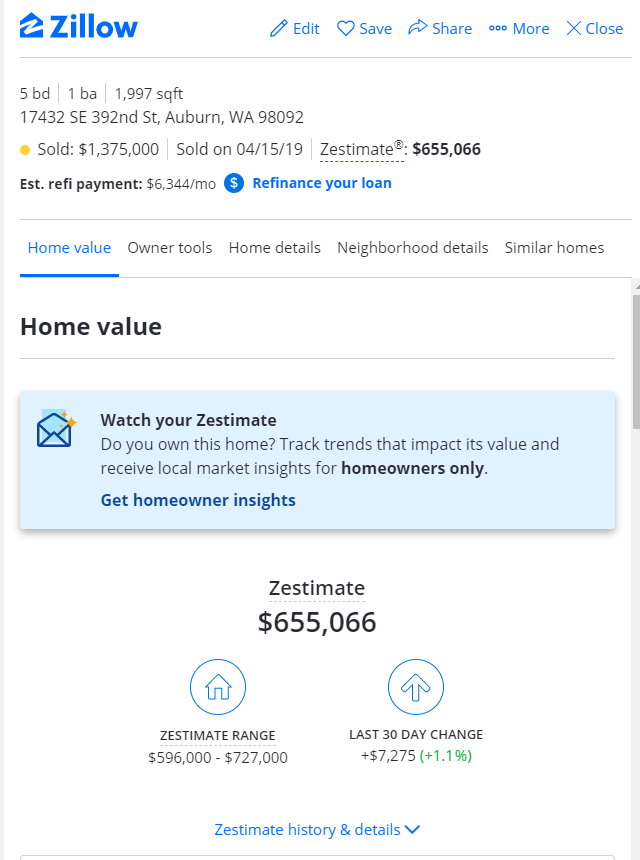

# Model 11 - Square Root SalePrice

In [368]:
df11 = df10.copy()

In [369]:
df11['sale_sqrt'] = np.sqrt(df11['SalePrice'])

In [373]:
#replace saleprice with its square rroot equivalent
features_11 = ['AdjacentGreenbelt', 'excellent_view', 'Topography', 'InadequateParking', 'MtRainier', 'Olympics', 'Cascades',\
               'Territorial', 'SeattleSkyline', 'PugetSound', 'LakeWashington', 'LakeSammamish', 'SmallLakeRiverCreek',\
               'OtherView', 'WfntLocation', 'Easements', 'SaleWarning', 'ViewUtilization', 'has_porch', 'has_renovation',\
              'has_basement', 'TrafficNoise', 'has_problem', 'SqFtTotLiving', 'SqFt1stFloor', 'latitude',\
               'dist_to_exp', 'age', 'sale_sqrt', 'SqFt2ndFloor', 'heating', 'bedbath']


categoricals11 = ['HeatSource', 'Access', 'ZipCode', 'Condition', 'Bedrooms', 'BldgGrade']

In [376]:
cat11_ohe = df11[categoricals11]
encoder = OneHotEncoder(drop='first', sparse=False)
encoder11 = encoder.fit(cat11_ohe)
cat11_ohe = encoder11.transform(cat11_ohe)
cat11_ohe = pd.DataFrame(cat11_ohe, columns = encoder11.get_feature_names())
cont11 = df11[features_11]
cat11_ohe.reset_index(drop=True, inplace=True)
cont11.reset_index(drop=True, inplace=True)
preprocessed11 = pd.concat([cont11, cat11_ohe], axis=1)
X_train11 = preprocessed11.drop('sale_sqrt', axis=1)
y_train11 = preprocessed11['sale_sqrt']

In [377]:
X_int11 = sm.add_constant(X_train11)
model11 = sm.OLS(y_train11, X_int11).fit()
model11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              sale_sqrt   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     759.4
Date:                Fri, 05 Mar 2021   Prob (F-statistic):               0.00
Time:                        02:54:08   Log-Likelihood:                -83091.
No. Observations:               14580   AIC:                         1.664e+05
Df Residuals:                   14462   BIC:                         1.673e+05
Df Model:                         117                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -6177.0263   1550.266     -3.984      0.000   -9215.747   -3138.306
AdjacentGreenbelt       0.9763      4.054      0.241      0.810      -6.971       8.923
excellent_view         76.2998      6.721     11.352      0.000      63.126      89.474
Topography             -6.5203      2.427     -2.686      0.007     -11.278      -1.762
InadequateParking      -3.3323      1.565     -2.130      0.033      -6.399      -0.266
MtRainier              31.3281      7.468      4.195      0.000      16.691      45.965
Olympics               26.0022      5.559      4.677      0.000      15.105      36.899
Cascades                0.6247      4.543      0.138      0.891      -8.280       9.530
Territorial             4.7553      3.191      1.490      0.136      -1.499      11.010
SeattleSkyline         32.6076      7.263      4.490      0.000      18.372      46.844
PugetSound             33.6681      5.025      6.700      0.000      23.819      43.518
LakeWashington         77.0315      4.912     15.682      0.000      67.403      86.660
LakeSammamish          68.0800     10.034      6.785      0.000      48.412      87.748
SmallLakeRiverCreek   -21.1051      9.322     -2.264      0.024     -39.377      -2.833
OtherView             -46.9109     10.992     -4.268      0.000     -68.457     -25.365
WfntLocation          157.3321      8.563     18.374      0.000     140.548     174.116
Easements              12.6190      4.598      2.744      0.006       3.606      21.632
SaleWarning           -68.9848      2.630    -26.230      0.000     -74.140     -63.830
ViewUtilization        28.3855      4.833      5.873      0.000      18.912      37.859
has_porch              10.1808      1.309      7.779      0.000       7.616      12.746
has_renovation         27.5860      2.974      9.275      0.000      21.756      33.416
has_basement            5.6639      1.905      2.973      0.003       1.929       9.399
TrafficNoise          -15.3279      1.787     -8.579      0.000     -18.830     -11.826
has_problem           -11.9730      3.231     -3.706      0.000     -18.305      -5.641
SqFtTotLiving           0.0622      0.002     27.732      0.000       0.058       0.067
SqFt1stFloor            0.0358      0.003     12.224      0.000       0.030       0.042
latitude              139.9314     32.754      4.272      0.000      75.730     204.133
dist_to_exp            -4.9341      0.394    -12.524      0.000      -5.706      -4.162
age                     0.3457      0.037      9.224      0.000       0.272       0.419
SqFt2ndFloor            0.0271      0.002     11.560      0.000       0.022       0.032
heating                -2.4787      1.861     -1.332      0.183      -6.127       1.170
bedbath               -14.9047      1.524     -9.782      0.000     -17.891     -11.918
x0_

In [378]:
# I will now check run the model using sk-learn
linreg = LinearRegression()

# Fit on training data
linreg11 = linreg.fit(X_train11, y_train11)

scores11 = cross_val_score(
            linreg11, 
            X_train11,
            y_train11,
            cv=10,
            scoring="neg_mean_squared_error"
)

rmse_scores11 = np.sqrt(-scores11)
display(rmse_scores11)
display(rmse_scores11.mean())
display(rmse_scores11.std())

array([100.326468  ,  53.94049075,  53.39880434,  57.42571756,
        64.57465925,  62.23652308,  63.71523161,  70.42879379,
        76.60313928, 187.33225625])

78.99820839212325

38.394641698327476

In [379]:
summary.loc[10] = ['Multiple Linear Model 9', 'MLP 7 Sqrt Sale Price', model11.df_model, round(model11.rsquared,3)\
                  , round(model11.rsquared_adj,3), rmse_scores11.mean(), rmse_scores11.std(),\
                  round((sms.jarque_bera(model11.resid)[0]),0)]

summary

Model  \
0   Simple Model - one independent variable   
1           Simple Model - outliers removed   
2                   Multiple Linear Model 1   
3                   Multiple Linear Model 2   
4                   Multiple Linear Model 3   
5                   Multiple Linear Model 4   
6                   Multiple Linear Model 5   
7                   Multiple Linear Model 6   
8                   Multiple Linear Model 7   
9                   Multiple Linear Model 8   
10                  Multiple Linear Model 9   

                              Description   No. Features    R^2  Adj R^2  \
0                  Square ft Total living            1.0  0.389    0.389   
1                  Square ft Total living            1.0  0.354    0.354   
2                     Continuous features            4.0  0.535    0.535   
3   Continuous features + age/dist_to_exp            6.0  0.567    0.566   
4            continuous + binary features           29.0  0.622    0.622   
5      continuous + binary features + cat          139.0  0.816    0.814   
6             MLP 4 + SqFt2nd + Clean Cat          123.0  0.823    0.821   
7        MLP 5 outliers longitude removed          116.0  0.834    0.833   
8                       MLP 6 + bathrooms          119.0  0.835    0.834   
9                    MLP 7 Log Sale Price          117.0  0.854    0.853   
10                  MLP 7 Sqrt Sale Price          117.0  0.860    0.859   

             RMSE        RMSE sd         JB  
0   398611.000000  342506.000000  9825842.0  
1   294579.000000  168991.000000     7132.0  
2   238663.000000  158954.000000    18348.0  
3   236962.000000  153473.000000    16023.0  
4   227275.000000  146517.000000    16416.0  
5   166951.000000  118312.000000   165256.0  
6   164932.000000  118703.000000   206712.0  
7   158260.000000  111643.000000    32901.0  
8   157905.000000  111436.000000    32792.0  
9        0.182373       0.073137   196501.0  
10      78.998208      38.394642    35088.0

# Model 12 - Cube Root other continuous variables 

In [381]:
df12 = df11.copy()

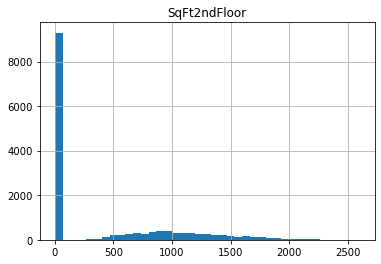

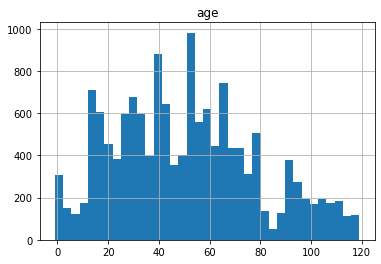

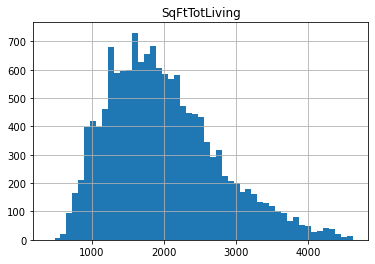

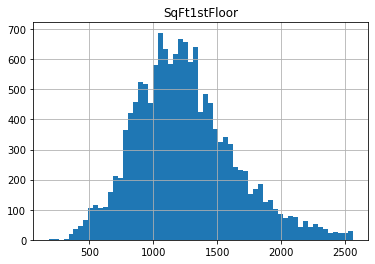

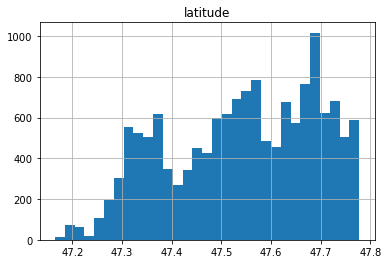

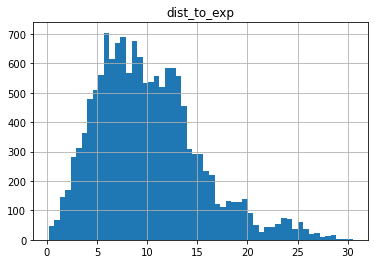

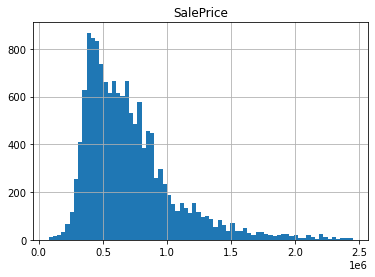

In [389]:
cont_12 = ['SqFt2ndFloor', 'age', 'SqFtTotLiving', 'SqFt1stFloor', 'latitude', 'dist_to_exp', 'SalePrice']
for col in cont_12:
    df12[col].hist(bins='auto')
    plt.title(col)
    plt.show()
       
    

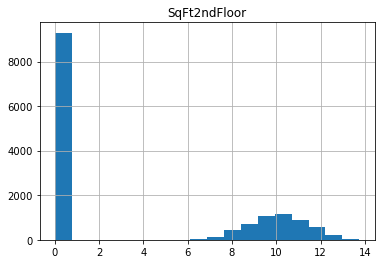

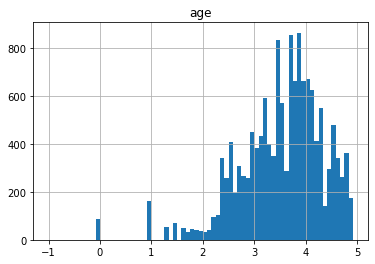

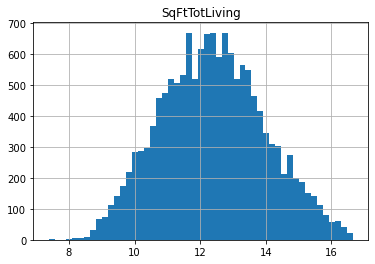

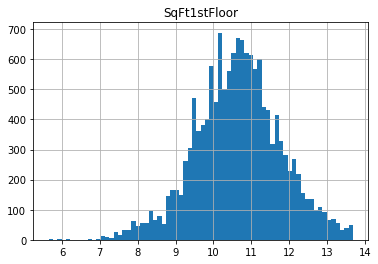

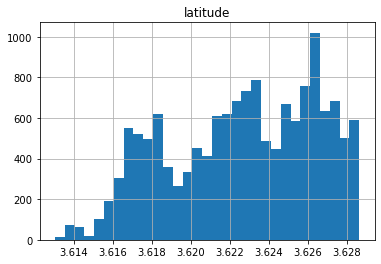

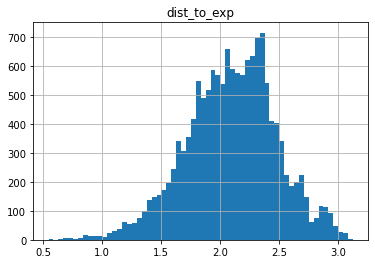

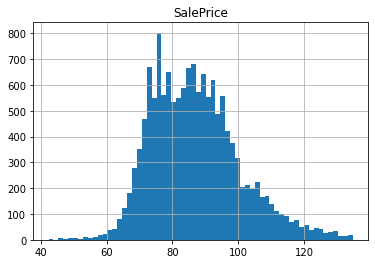

In [390]:
for col in cont_12:
    np.cbrt(df12[col]).hist(bins='auto')
    plt.title(col)
    plt.show()
    

In [386]:
df12['duplex'] = 0
df12.loc[(df12['SqFt2ndFloor'] > 0),'duplex'] = 1

In [392]:
# cube root transform those that make sense
df12['SqFtTotLiving_cb'] = np.cbrt(df12['SqFtTotLiving'])
df12['SqFt1stFloor_cb'] = np.cbrt(df12['SqFt1stFloor'])
df12['dist_to_exp_cb'] = np.cbrt(df12['dist_to_exp'])
df12['SalePrice_cb'] = np.cbrt(df12['SalePrice'])

In [399]:
#remove adjacent greenbelt as it has been consistently insignificant
features_12 = ['excellent_view', 'Topography', 'InadequateParking', 'MtRainier', 'Olympics', 'Cascades',\
               'Territorial', 'SeattleSkyline', 'PugetSound', 'LakeWashington', 'LakeSammamish', 'SmallLakeRiverCreek',\
               'OtherView', 'WfntLocation', 'Easements', 'SaleWarning', 'ViewUtilization', 'has_porch', 'has_renovation',\
              'has_basement', 'TrafficNoise', 'has_problem', 'SqFtTotLiving_cb', 'SqFt1stFloor_cb', 'latitude',\
               'dist_to_exp_cb', 'age', 'SalePrice_cb', 'duplex', 'heating', 'bedbath']


categoricals12 = ['HeatSource', 'Access', 'ZipCode', 'Condition', 'Bedrooms', 'BldgGrade']

In [400]:
cat12_ohe = df12[categoricals12]
encoder = OneHotEncoder(drop='first', sparse=False)
encoder12 = encoder.fit(cat12_ohe)
cat12_ohe = encoder12.transform(cat12_ohe)
cat12_ohe = pd.DataFrame(cat12_ohe, columns = encoder12.get_feature_names())
cont12 = df12[features_12]
cat12_ohe.reset_index(drop=True, inplace=True)
cont12.reset_index(drop=True, inplace=True)
preprocessed12 = pd.concat([cont12, cat12_ohe], axis=1)
X_train12 = preprocessed12.drop('SalePrice_cb', axis=1)
y_train12 = preprocessed12['SalePrice_cb']

In [401]:
X_int12 = sm.add_constant(X_train12)
model12 = sm.OLS(y_train12, X_int12).fit()
model12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           SalePrice_cb   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     766.8
Date:                Fri, 05 Mar 2021   Prob (F-statistic):               0.00
Time:                        03:23:55   Log-Likelihood:                -44288.
No. Observations:               14580   AIC:                         8.881e+04
Df Residuals:                   14463   BIC:                         8.970e+04
Df Model:                         116                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -515.7565    108.112     -4.771      0.000    -727.670    -303.843
excellent_view          4.8105      0.469     10.249      0.000       3.891       5.731
Topography             -0.4319      0.169     -2.549      0.011      -0.764      -0.100
InadequateParking      -0.2105      0.110     -1.922      0.055      -0.425       0.004
MtRainier               2.4528      0.522      4.702      0.000       1.430       3.475
Olympics                1.7525      0.388      4.513      0.000       0.991       2.514
Cascades                0.1905      0.317      0.600      0.548      -0.431       0.813
Territorial             0.3874      0.223      1.738      0.082      -0.049       0.824
SeattleSkyline          1.8789      0.507      3.705      0.000       0.885       2.873
PugetSound              2.2702      0.351      6.470      0.000       1.582       2.958
LakeWashington          4.6887      0.344     13.637      0.000       4.015       5.363
LakeSammamish           4.2133      0.701      6.014      0.000       2.840       5.586
SmallLakeRiverCreek    -1.1339      0.651     -1.741      0.082      -2.410       0.142
OtherView              -3.4644      0.768     -4.512      0.000      -4.969      -1.960
WfntLocation           10.6881      0.598     17.869      0.000       9.516      11.861
Easements               0.7633      0.321      2.379      0.017       0.134       1.392
SaleWarning            -5.2125      0.184    -28.374      0.000      -5.573      -4.852
ViewUtilization         1.7185      0.338      5.083      0.000       1.056       2.381
has_porch               0.8608      0.091      9.439      0.000       0.682       1.040
has_renovation          1.8617      0.208      8.952      0.000       1.454       2.269
has_basement           -0.1402      0.126     -1.114      0.265      -0.387       0.107
TrafficNoise           -1.0805      0.125     -8.659      0.000      -1.325      -0.836
has_problem            -0.8006      0.226     -3.548      0.000      -1.243      -0.358
SqFtTotLiving_cb        2.3014      0.070     33.038      0.000       2.165       2.438
SqFt1stFloor_cb         0.7680      0.073     10.487      0.000       0.624       0.912
latitude               11.8160      2.283      5.175      0.000       7.340      16.292
dist_to_exp_cb         -4.6664      0.330    -14.123      0.000      -5.314      -4.019
age                     0.0181      0.003      6.816      0.000       0.013       0.023
duplex                  0.8270      0.168      4.918      0.000       0.497       1.157
heating                -0.1912      0.130     -1.471      0.141      -0.446       0.064
bedbath                -1.0599      0.108     -9.809      0.000      -1.272      -0.848
x0_Gas                  0.5118      0.139      3.688      0.000       0.240       0.784
x0_

In [402]:
# I will now check run the model using sk-learn
linreg = LinearRegression()

# Fit on training data
linreg12 = linreg.fit(X_train12, y_train12)

scores12 = cross_val_score(
            linreg12, 
            X_train12,
            y_train12,
            cv=10,
            scoring="neg_mean_squared_error"
)

rmse_scores12 = np.sqrt(-scores12)
display(rmse_scores12)
display(rmse_scores12.mean())
display(rmse_scores12.std())

array([ 8.06316755,  3.91180931,  3.83752411,  4.0072848 ,  4.42454561,
        4.28207045,  4.37027759,  4.89214596,  5.18684188, 11.64592415])

5.46215914199116

2.371203248306395

In [404]:
summary.loc[11] = ['Multiple Linear Model 10', 'MLP 7 cbrt Sale Price - adjacentGreen', model12.df_model, round(model12.rsquared,3)\
                  , round(model12.rsquared_adj,3), rmse_scores12.mean(), rmse_scores12.std(),\
                  round((sms.jarque_bera(model12.resid)[0]),0)]

summary

Model  \
0   Simple Model - one independent variable   
1           Simple Model - outliers removed   
2                   Multiple Linear Model 1   
3                   Multiple Linear Model 2   
4                   Multiple Linear Model 3   
5                   Multiple Linear Model 4   
6                   Multiple Linear Model 5   
7                   Multiple Linear Model 6   
8                   Multiple Linear Model 7   
9                   Multiple Linear Model 8   
10                  Multiple Linear Model 9   
11                 Multiple Linear Model 10   

                              Description   No. Features    R^2  Adj R^2  \
0                  Square ft Total living            1.0  0.389    0.389   
1                  Square ft Total living            1.0  0.354    0.354   
2                     Continuous features            4.0  0.535    0.535   
3   Continuous features + age/dist_to_exp            6.0  0.567    0.566   
4            continuous + binary features           29.0  0.622    0.622   
5      continuous + binary features + cat          139.0  0.816    0.814   
6             MLP 4 + SqFt2nd + Clean Cat          123.0  0.823    0.821   
7        MLP 5 outliers longitude removed          116.0  0.834    0.833   
8                       MLP 6 + bathrooms          119.0  0.835    0.834   
9                    MLP 7 Log Sale Price          117.0  0.854    0.853   
10                  MLP 7 Sqrt Sale Price          117.0  0.860    0.859   
11  MLP 7 cbrt Sale Price - adjacentGreen          116.0  0.860    0.859   

             RMSE        RMSE sd         JB  
0   398611.000000  342506.000000  9825842.0  
1   294579.000000  168991.000000     7132.0  
2   238663.000000  158954.000000    18348.0  
3   236962.000000  153473.000000    16023.0  
4   227275.000000  146517.000000    16416.0  
5   166951.000000  118312.000000   165256.0  
6   164932.000000  118703.000000   206712.0  
7   158260.000000  111643.000000    32901.0  
8   157905.000000  111436.000000    32792.0  
9        0.182373       0.073137   196501.0  
10      78.998208      38.394642    35088.0  
11       5.462159       2.371203    53457.0